# Workspace Setup

** **

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import plotly.express as px
import scipy.stats as _stats
import datetime as dt
import itertools
import folium
import geopandas

from matplotlib import pyplot as plt
from IPython.display import display, HTML, Image
from helper_functions import *
from scipy import stats
from folium.plugins import MarkerClusteg

### Settings

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    
    pd.options.display.max_columns = 200
    pd.options.display.max_rows = 200
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
    #warnings.filterwarnings("ignore")

In [3]:
jupyter_settings()

### Auxiliar Functions

In [4]:
# Summary Statistical functions

def descriptive_stats(data: pd.DataFrame, bound_dist: int):
    
    mean = pd.DataFrame(data.mean())
    std = pd.DataFrame(data.std())
    median = pd.DataFrame(data.median())
    mode = pd.DataFrame(data.mode().T.iloc[:,0])

    q1,q3 = pd.DataFrame(data.quantile(0.25)), pd.DataFrame(data.quantile(0.75))
    
    iqr = q3[0.75] - q1[0.25]
    lower_bound, upper_bound = q1[0.25] - (bound_dist*iqr), q3[0.75] + (bound_dist*iqr)

    maximum = pd.DataFrame(data.max())
    minimum = pd.DataFrame(data.min())
    
    p1,p5,p95,p99 = pd.DataFrame(data.quantile(0.01)),pd.DataFrame(data.quantile(0.05)),pd.DataFrame(data.quantile(0.95)),pd.DataFrame(data.quantile(0.99))  

    skew = pd.DataFrame(data.skew())
    kurtosis = pd.DataFrame(data.kurtosis())

    descriptive_statistics = pd.concat([mean,std,minimum,p1,p5,lower_bound,q1,mode,median,q3,upper_bound,p95,p99,maximum,skew,kurtosis],axis=1)
    
    descriptive_statistics.columns = ['mean','std','minimum','p1','p5','lower_bound','q1','mode','median','q3','upper_bound','p95','p99','maximum',
                                      'skew','kurtosis']
    
    return descriptive_statistics

def group_descriptive_stats(data: pd.DataFrame, agg_feature: str, info_feature: str, bound_dist: int):
    
    grouped_data = data[[agg_feature,info_feature]].groupby(agg_feature)
    
    mean = grouped_data.mean()
    std = grouped_data.std()
    median = grouped_data.median()
    mode = grouped_data.agg([stats.mode]).apply(lambda x: x[0][0][0],axis=1)

    q1,q3 = grouped_data.quantile(0.25), grouped_data.quantile(0.75)
    
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - (bound_dist*iqr), q3 + (bound_dist*iqr)

    maximum = grouped_data.max()
    minimum = grouped_data.min()
    
    p1,p5,p95,p99 = grouped_data.quantile(0.01),grouped_data.quantile(0.05),grouped_data.quantile(0.95),grouped_data.quantile(0.99)
    
    skew = grouped_data.skew()
    kurtosis = grouped_data.apply(pd.DataFrame.kurt).drop(agg_feature,axis=1)
    
    grouped_descriptive_statistics = pd.concat([mean,std,minimum,p1,p5,lower_bound,q1,mode,median,q3,upper_bound,p95,p99,maximum,skew,kurtosis],axis=1)
    
    grouped_descriptive_statistics.columns = ['mean','std','minimum','p1','p5','lower_bound','q1','mode','median','q3','upper_bound','p95','p99','maximum','skew','kurtosis']
    
    return grouped_descriptive_statistics

def select_num_attr(data: pd.DataFrame):
    
    return data.select_dtypes(include=['int64', 'float64'])

def get_geofile(url):
    geofile = geopandas.read_file(url)
    return geofile

In [5]:
# Outlier identification functions

def z_score(data, k_dev):
    mean = np.round(data.mean(), decimals=2)
    std_dev = np.round(data.std(), decimals=2)

    z_scores = [ (x - mean)/std_dev for x in data ]
    return data[(np.abs(z_scores) > k_dev)]

def modified_zscore(data, thresh):

    median = np.median(data)
    median_absolute_deviation = np.median([np.abs(x - median) for x in data])

    modified_z_scores = [0.6745 * (x - median) / median_absolute_deviation for x in data]
    return data[(np.abs(modified_z_scores) > thresh)]

def iqr(data, dist):
  
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    return data[(data < (Q1 - (dist * IQR))) | (data > (Q3 + (dist * IQR)))]

def number_iqr_outliers(data: pd.DataFrame,dist: int) -> pd.DataFrame:
    
    outliers = {}
    for feature in data.columns:
    #     print(f"{feature} outliers", end="\n")
    #     print(iqr(num_attributes[feature], 1.5))
        outliers[feature] = iqr(num_attributes[feature], dist)
    num_outliers = [outliers[feature].shape[0] for feature in outliers.keys()]
    perc_records = [(n_outliers/data.shape[0])*100 for n_outliers in num_outliers]
    outliers_data = {'num_iqr_outliers':num_outliers,'perc_outlier_records':perc_records}
    iqr_outliers = pd.DataFrame(data=outliers_data, index=data.columns.to_list())
    
    return iqr_outliers

** **

# Data Import and Setup

** **

### Import data
** **

In [6]:
orig_df = pd.read_csv('data/kc_house_data.csv')
house_df_eda = orig_df.copy(deep=True)

### General Info

** **

In [7]:
house_df_eda.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [8]:
house_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [9]:
house_df_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21613.00,4580301520.86,2876565571.31,1000102.00,2123049194.00,3904930410.00,7308900445.00,9900000190.00
price,21613.00,540088.14,367127.20,75000.00,321950.00,450000.00,645000.00,7700000.00
bedrooms,21613.00,3.37,0.93,0.00,3.00,3.00,4.00,33.00
bathrooms,21613.00,2.11,0.77,0.00,1.75,2.25,2.50,8.00
sqft_living,21613.00,2079.90,918.44,290.00,1427.00,1910.00,2550.00,13540.00
sqft_lot,21613.00,15106.97,41420.51,520.00,5040.00,7618.00,10688.00,1651359.00
floors,21613.00,1.49,0.54,1.00,1.00,1.50,2.00,3.50
waterfront,21613.00,0.01,0.09,0.00,0.00,0.00,0.00,1.00
view,21613.00,0.23,0.77,0.00,0.00,0.00,0.00,4.00
condition,21613.00,3.41,0.65,1.00,3.00,3.00,4.00,5.00


** **

# 1. Exploratory Data Analysis
** **

### 1.1 Data Dimensionality
** **

It is a small sized dataset, and and it will not suffer from the curse of dimensionality.

In [10]:
print('Number of Rows:{}'.format(house_df_eda.shape[0]))
print('Number of Columns {}'.format(house_df_eda.shape[1]))

Number of Rows:21613
Number of Columns 21


### 1.2 Attributes Name and Description
** **

**id** - its a unique identifier number for each unique house

**date** - its the date when the house were sold

**price** - its the selling price when the house was sold

**bedrooms** - number of bedrooms in the house

**bathrooms** - number of bathrooms in the house, where a fraction like 0.25 represents a bathroom sink, shower or toilet

**sqft_living** - square footage of the apartments interior living space

**sqft_lot** - the size of the land in square feet

**floors** - number of floors in the house

**waterfront** - if there is a waterview from the house

**view** - an index from 0 to 4 of how good the view of the property was or how many views the house has.

**condition** - the house preservation condition

**grade** - a rank from 1 to 13, which ranks the construction quality

**sqft_above** - the size of the house above the ground level in square feet

**sqft_basement** - the size of the house below the ground level in square feet

**yr_built** - the year the house was initially built

**yr_renovated** - the year of the house's last renovation

**zipcode** - what zipcode area the house is in

**lat** - Latitude

**long** - Longitude

**sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors (possibly)

**sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

** **

### 1.3 Attributes Type and Data type conversions
** **

In [11]:
house_df_eda.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

>#### Date reformat type

Because it will be handled easily as a date variable type

In [12]:
house_df_eda.date = pd.to_datetime(house_df_eda.date)

In [13]:
house_df_eda.date[0]

Timestamp('2014-10-13 00:00:00')

### 1.4 Attributes Descriptive Statistics (Summary Statistics)
** **

In [14]:
num_attributes = select_num_attr(house_df_eda)

In [15]:
num_attributes.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [16]:
bound_dist = 1.5
pd.concat([descriptive_stats(num_attributes,bound_dist),number_iqr_outliers(num_attributes,bound_dist)],axis=1)

,mean,std,minimum,p1,p5,lower_bound,q1,mode,median,q3,upper_bound,p95,p99,maximum,skew,kurtosis,num_iqr_outliers,perc_outlier_records
id,4580301520.86,2876565571.31,1000102.00,122033870.92,512480335.00,-5655727682.50,2123049194.00,795000620.00,3904930410.00,7308900445.00,15087677321.50,9297300429.00,9558728047.20,9900000190.00,0.24,-1.26,0,0.00
price,540088.14,367127.20,75000.00,153500.36,210000.00,-162625.00,321950.00,350000.00,450000.00,645000.00,1129575.00,1156480.00,1964400.00,7700000.00,4.02,34.59,1146,5.30
bedrooms,3.37,0.93,0.00,2.00,2.00,1.50,3.00,3.00,3.00,4.00,5.50,5.00,6.00,33.00,1.97,49.06,546,2.53
bathrooms,2.11,0.77,0.00,1.00,1.00,0.62,1.75,2.50,2.25,2.50,3.62,3.50,4.25,8.00,0.51,1.28,571,2.64
sqft_living,2079.90,918.44,290.00,720.00,940.00,-257.50,1427.00,1300.00,1910.00,2550.00,4234.50,3760.00,4978.80,13540.00,1.47,5.24,572,2.65
sqft_lot,15106.97,41420.51,520.00,1013.12,1800.00,-3432.00,5040.00,5000.00,7618.00,10688.00,19160.00,43339.20,213008.00,1651359.00,13.06,285.08,2425,11.22
floors,1.49,0.54,1.00,1.00,1.00,-0.50,1.00,1.00,1.50,2.00,3.50,2.00,3.00,3.50,0.62,-0.48,0,0.00
waterfront,0.01,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,11.39,127.63,163,0.75
view,0.23,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,4.00,4.00,3.40,10.89,2124,9.83
condition,3.41,0.65,1.00,3.00,3.00,1.50,3.00,3.00,3.00,4.00,5.50,5.00,5.00,5.00,1.03,0.53,30,0.14


> ##### Study each attribute variability, centrality/localization, distribution skewness and kurtosis

**Price :**

Housing price is varying from 75 000.00\\$ to 7 700 000.00\\$ which reveals a wide range of values. By looking to median price, 50% of the houses on King County costs equal or less than 450 000.00\\$, and comparing to the mean value, 540 088.14\\$, I can assume that are houses with much higher prices pushing the mean far from the median, so the distribution is skewed right with a skew of 4.02. In terms of more price concentration of houses, by looking at kurtosis there are many houses around the mode of 350 000.00\\$. Since it is right skewed the most interesting extreme values are to the left, and 75% of the houses price value are equal or below 645 000.00\\$, and 94.70% of the houses are up to 1 129 575.00\\$, there being 1146 houses above this value that could be statistically considered outliers.

### 1.5 Identify missing values and Duplicated records
***

>#### Missing Values

In [17]:
num_attributes.isnull().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [18]:
cat_attributes = house_df_eda.select_dtypes(exclude=['int64','float64'])

pd.isna(cat_attributes).sum()

date    0
dtype: int64

>#### Check Duplicates (Houses sold twice or more times)

In [19]:
len(house_df_eda['id'].unique())

21436

In [20]:
duplicated_ids = house_df_eda['id'].apply(lambda x: True if (sum(x == house_df_eda['id']) >= 2)\
                                                     else False)

Drop the duplicates but keep the most recent, because for this business purpose it is relevant the houses that are currently on market or the real estate portfolio.

In [21]:
house_df_eda.loc[duplicated_ids,['id','date','price', 'yr_renovated','zipcode']].drop_duplicates(subset=['id'], keep='last')

,id,date,price,yr_renovated,zipcode
94,6021501535,2014-12-23,700000.00,0,98117
314,4139480200,2014-12-09,1400000.00,0,98006
325,7520000520,2015-03-11,240500.00,1984,98146
346,3969300030,2014-12-29,239900.00,0,98178
372,2231500030,2015-03-24,530000.00,0,98133
718,8820903380,2015-01-02,730000.00,1990,98125
824,726049190,2015-02-18,431000.00,0,98133
837,8682262400,2015-05-13,419950.00,0,98053
1086,9834200885,2015-04-20,550000.00,0,98144
1129,8062900070,2015-02-13,369000.00,0,98056


### 1.6 Data Granularity
***

>#### Geographic Data

The geographic data attributes *latitude* and *longitude* are in their finest granularity, but *zipcode* despite being in their purest form in terms of value, it could be transformed into other finer variables to describe specifically the location of the house, for example, the street or a more coarse one as county.

>#### Temporal Data

The data attributes *yr_built* and *yr_renovated* are interval-based and nominal, respectively. And both have an year level of granularity. The *date* attribute can be considered as interval-based with a day level of temporal granularity

In [22]:
# house_df_eda['yr_built'].sort_values().unique()

In [23]:
# house_df_eda['yr_renovated'].sort_values().unique()

In [24]:
# house_df_eda['date'].sort_values().unique()

>#### Numerical Data 

All numeric variables {'id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15'}
      
have the finest granularity, they are not composed or discretized in any way.

### 1.7 Data Distribution
***

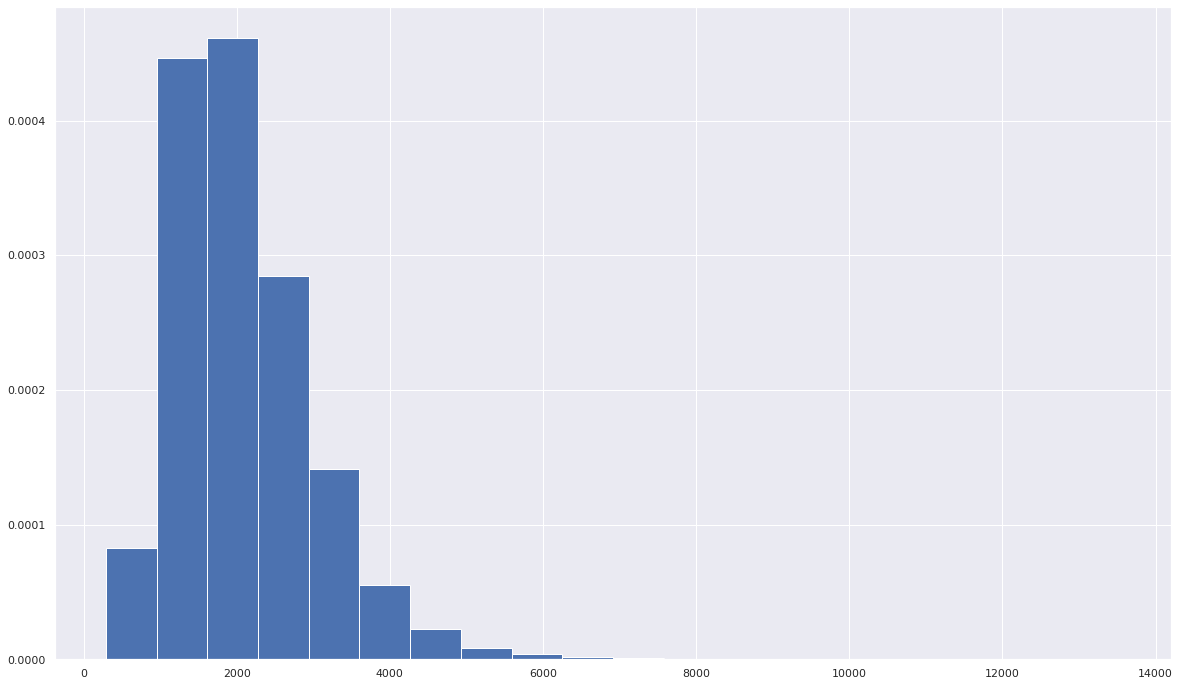

In [25]:
values = num_attributes['sqft_living'].sort_values().values
tuplex = plt.hist(values, 20, density=True)

Rows 7, Columns 3
Feature id
Feature price
Feature bedrooms
Feature bathrooms
Feature sqft_living
Feature sqft_lot
Feature floors
Feature waterfront
Feature view
Feature condition
Feature grade
Feature sqft_above
Feature sqft_basement
Feature yr_built
Feature yr_renovated
Feature zipcode
Feature lat
Feature long
Feature sqft_living15
Feature sqft_lot15


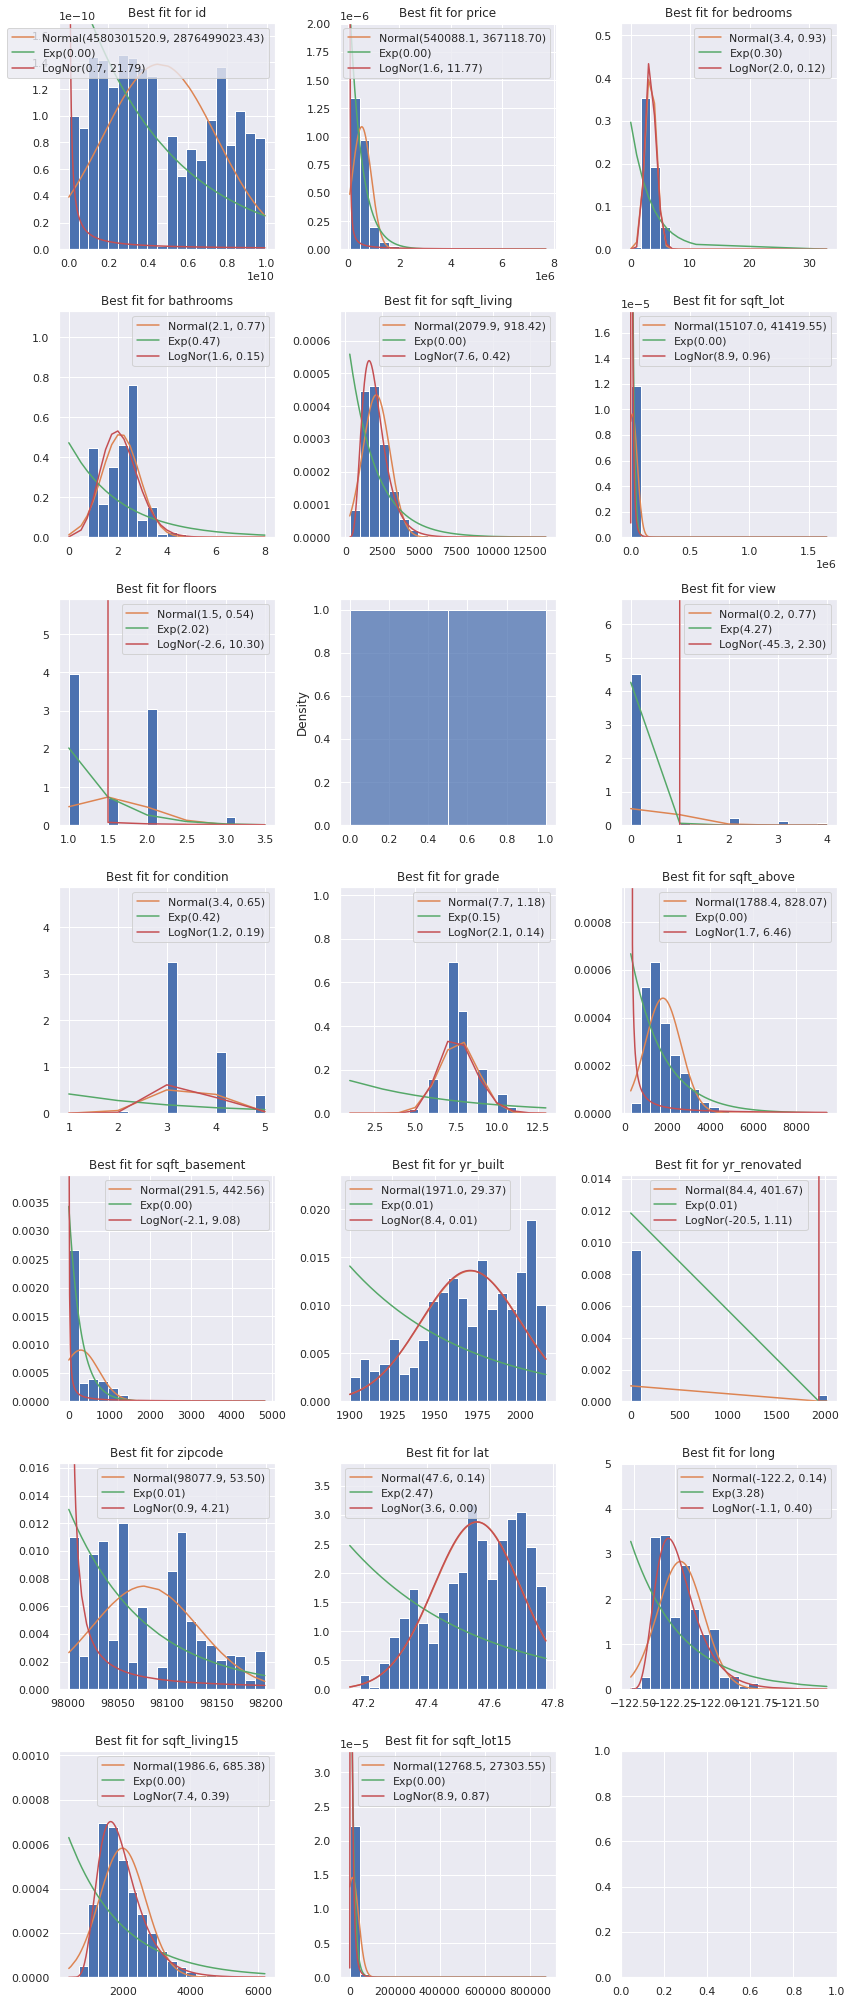

In [26]:
rows, cols = choose_grid(len(num_attributes.columns))

iterate_through_data(num_attributes,num_attributes.columns,rows,cols)

In [27]:
identify_best_fit_distribution(num_attributes,'price')

(540088.1417665294, 367118.7031813723)

(75000.0, 465088.1417665294)

(11.772290708305558, 74999.99999999999, 5.139744617075861)


Distributions listed by Betterment of fit:
............................................
  Distribution  chi_square
0         norm    10011.41
1        expon    15939.56
2      lognorm   186500.36


'norm'

In [28]:
identify_best_fit_distribution(num_attributes,'sqft_lot')

(15106.967565816869, 41419.55327262768)

(520.0, 14586.967565816869)

(0.9585570130585304, 343.4371825862659, 7513.086087116011)


Distributions listed by Betterment of fit:
............................................
  Distribution  chi_square
0      lognorm     2868.73
1        expon     7064.00
2         norm    72229.81


'lognorm'

### 1.8 Data Sparsity
***

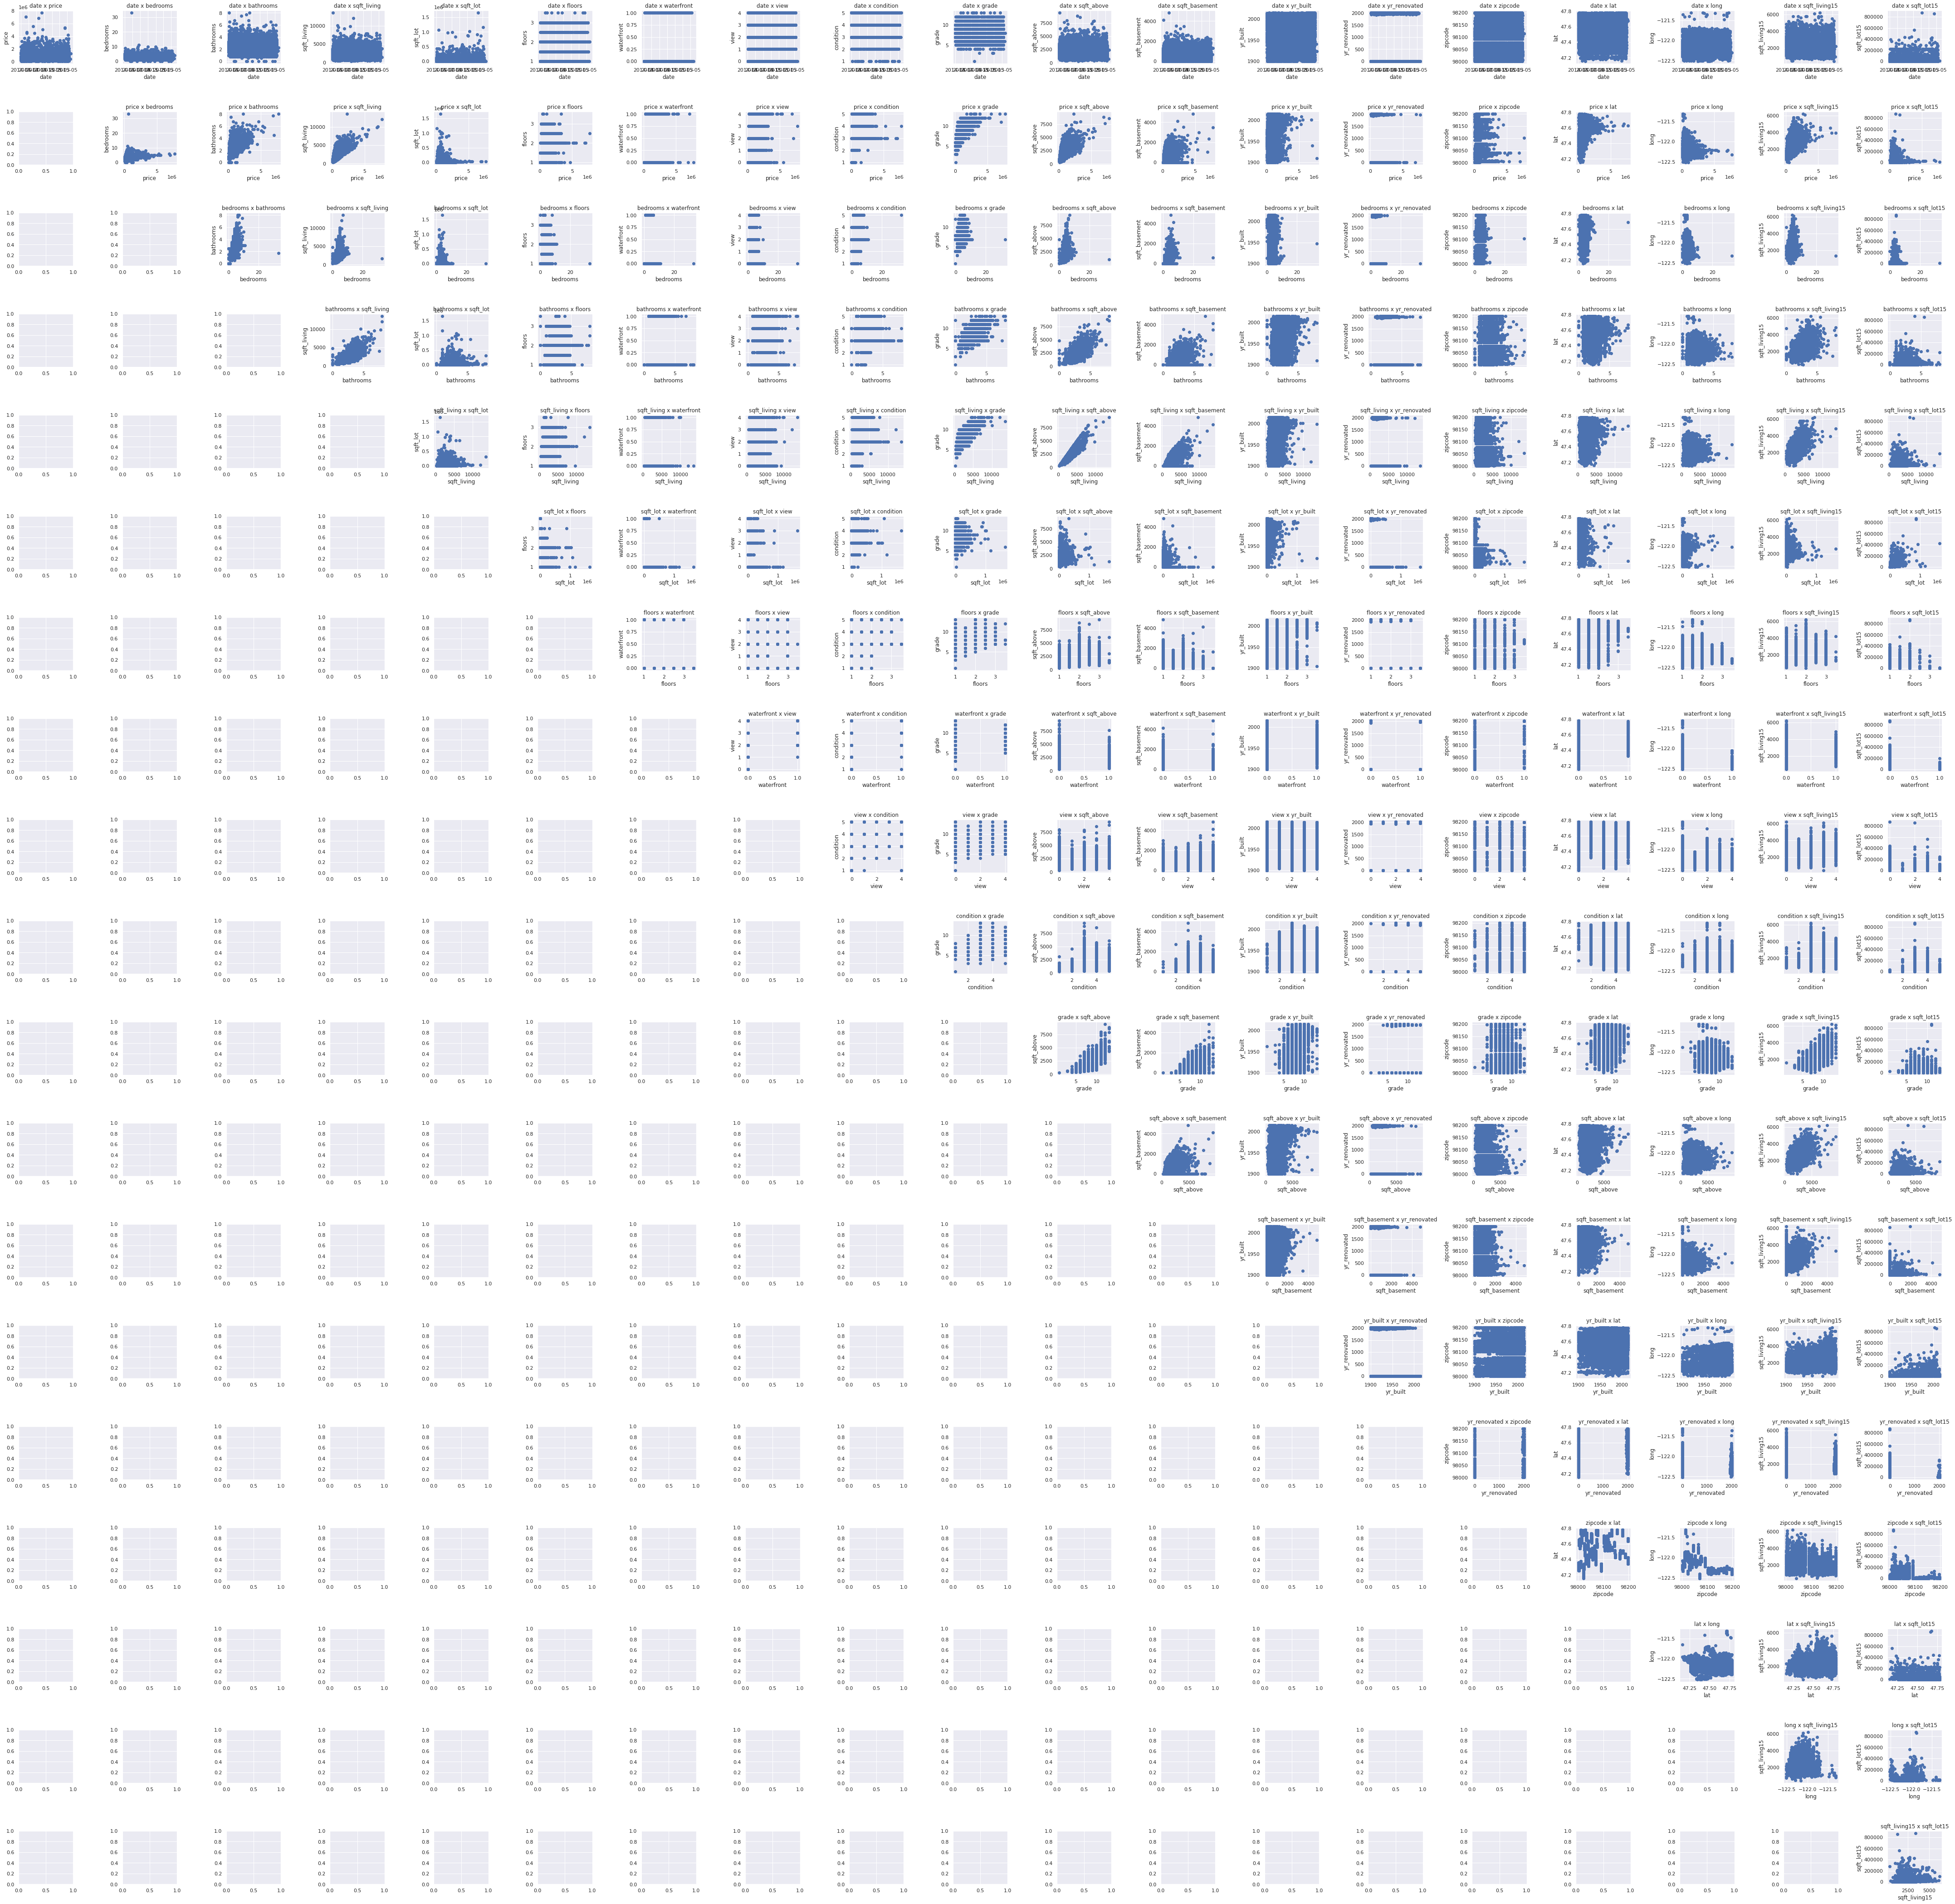

In [29]:
multiple_scatter_plots(house_df_eda.loc[:, house_df_eda.columns != 'id'])

> #### Correlation Analysis

It would be important to do some correlation analysis with the derived measures in the second cycle.

The *sqft_living* and *sqft_above* have an obvious high positive correlation.

Both *sqft_living* and *sqft_above* have an high positive correlation with the *grade*. So for the renovation question, it would be interesting to see if increasing *sqft_living* the selling price would also increase.

There is also an obvious high positive correlation of price with sqft_lot and grade. 

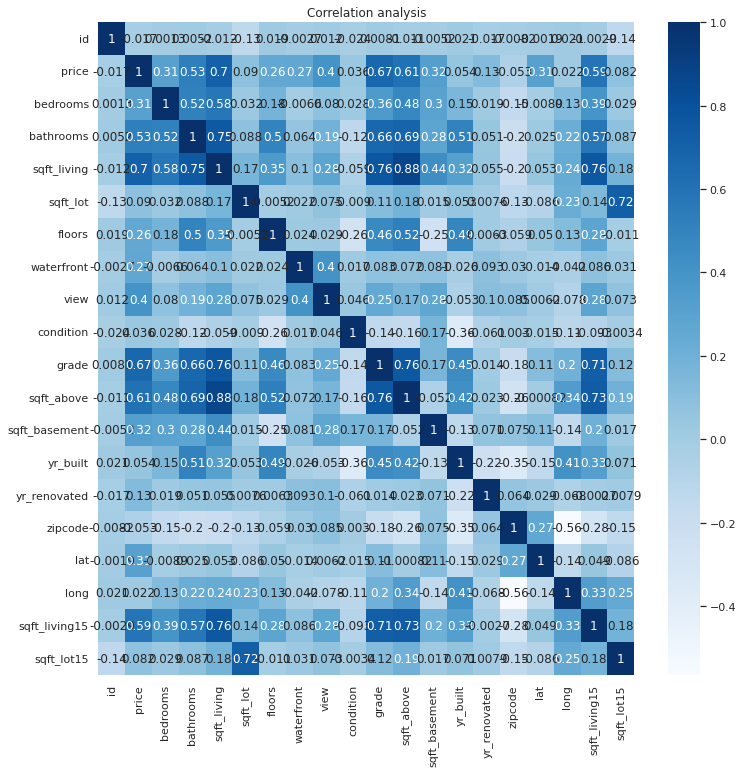

In [30]:
fig = plt.figure(figsize=[12, 12])
corr_mtx = num_attributes.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

> #### Outlier Analysis

Outliers still not analyzed

In [31]:
house_df_eda.loc[:5, ~house_df_eda.columns.isin(['id','date'])]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
5,1225000.00,4,4.50,5420,101930,1.00,0,0,3,11,3890,1530,2001,0,98053,47.66,-122.00,4760,101930


In [32]:
outliers = {}
for feature in num_attributes.loc[:, ~num_attributes.columns.isin(['id','date'])].columns:
#     print(f"{feature} outliers", end="\n")
#     print(iqr(num_attributes[feature], 1.5))
    outliers[feature] = iqr(num_attributes[feature], 1.5)

In [33]:
outliers['bedrooms'].unique()

array([ 1,  6,  7,  0,  8,  9, 11, 10, 33])

### 1.9 Identify Data Inconsistency
***

Some inconsitent records or records with inconsistent values must be removed if they are not relevant outliers, because they will bias the analysis and future model training.


In [34]:
house_df_eda_inconsistency = house_df_eda.copy(deep=True)

In [35]:
house_df_eda_inconsistency.loc[house_df_eda_inconsistency['bedrooms'] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000.00,0,0.00,3064,4764,3.50,0,2,3,7,3064,0,1990,0,98102,47.64,-122.32,2360,4000
3119,3918400017,2015-02-05,380000.00,0,0.00,1470,979,3.00,0,2,3,8,1470,0,2006,0,98133,47.71,-122.36,1470,1399
3467,1453602309,2014-08-05,288000.00,0,1.50,1430,1650,3.00,0,0,3,7,1430,0,1999,0,98125,47.72,-122.29,1430,1650
4868,6896300380,2014-10-02,228000.00,0,1.00,390,5900,1.00,0,0,2,4,390,0,1953,0,98118,47.53,-122.26,2170,6000
6994,2954400190,2014-06-24,1295650.00,0,0.00,4810,28008,2.00,0,0,3,12,4810,0,1990,0,98053,47.66,-122.07,4740,35061
8477,2569500210,2014-11-17,339950.00,0,2.50,2290,8319,2.00,0,0,3,8,2290,0,1985,0,98042,47.35,-122.15,2500,8751
8484,2310060040,2014-09-25,240000.00,0,2.50,1810,5669,2.00,0,0,3,7,1810,0,2003,0,98038,47.35,-122.05,1810,5685
9773,3374500520,2015-04-29,355000.00,0,0.00,2460,8049,2.00,0,0,3,8,2460,0,1990,0,98031,47.41,-122.17,2520,8050
9854,7849202190,2014-12-23,235000.00,0,0.00,1470,4800,2.00,0,0,3,7,1470,0,1996,0,98065,47.53,-121.83,1060,7200
12653,7849202299,2015-02-18,320000.00,0,2.50,1490,7111,2.00,0,0,3,7,1490,0,1999,0,98065,47.53,-121.83,1500,4675


In [36]:
house_df_eda_inconsistency.loc[house_df_eda_inconsistency['bedrooms'] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,2014-06-25,640000.00,33,1.75,1620,6000,1.00,0,0,5,7,1040,580,1947,0,98103,47.69,-122.33,1330,4700


In [37]:
house_df_eda_inconsistency.yr_renovated.sort_values().unique()

array([   0, 1934, 1940, 1944, 1945, 1946, 1948, 1950, 1951, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1962, 1963, 1964, 1965, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015])

In [38]:
len(house_df_eda_inconsistency.loc[house_df_eda_inconsistency['yr_renovated'] == 0])

20699

In [39]:
house_df_eda_inconsistency['living_area_above_and_basement'] = house_df_eda_inconsistency['sqft_living'] - (house_df_eda_inconsistency['sqft_above'] + house_df_eda_inconsistency['sqft_basement'])

In [40]:
house_df_eda_inconsistency.loc[house_df_eda_inconsistency['living_area_above_and_basement'] < 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,living_area_above_and_basement


#### Inconsistent features values

1. bedrooms
    1. There are some houses with 0 bedrooms, but may be houses with no purpose of living.
    
    2. There is some house record with 33 bedrooms with only 1040 square feet of infraestructure size


2. bathrooms
    1. There are some houses with bathrooms variable with decimal places, like 1.75, that could be inconsistency, but it is assumed each 1 unit of bathroom is a complete bathroom with sink, shower or toilet, each one being 0.25.


3. yr_renovated
    1. 20699 records have the year renovated variable equal to 0, saying that they were never renovated.
    
    
4. sqft_living - (sqft_above - sqft_basement)

    It wasn't found any inconsistency

#### Inconsistent records

### 1.10 Business Data Assumptions
***

It is important to do some business data assumption to better analyze the data and take interpretable insights.

1. **Region granularity**

    There is some difference between sub-regions in King County, so there must be a separation between regions, and have a specific analysis for each. Since a generalized analysis would nullify the correlation of each region, and would be harder to take insights. This region segmentation can be made in different granularities, that is it can be divided by North, South, and East Mountains, but it can also have a finer granularity that is for zipcode regions. Another finer granularity can be the street or street block by collecting that data from the latitude and longitude, and counting the number of houses per region to assess if there is enough data for each street to get significant statistical data.


2. **Bedrooms inconsistency**

    Houses with 0 bedrooms, may be for other purposes apart from living usage. (Confirm all records consistency, analysing one by one or doing some summary statistics)
    
    
3. **Year Renovated inconsistency**

    It can be assumed that houses with value 0 on yr_renovated is basically houses that have not been renovated yet.
    
    
4. **Condition vs Grade relevance**
    
    The condition variable it seems to have a higher weight in long-term than grade, in terms of evaluating
    which houses are better to buy, since the grade is the infraestructure construction quality and it cannot
    change so much with time, unlike condition that is the house preservation and it can it can increase with
    some maintenance works.

### 1.11 Attributes Usefulness for the tasks
***

First intuition without looking to EDA, and only based on the business understanding. (On the second cycle will be based on the EDA) 

**Business:** Buy and sell houses in Real Estate market, by taking profit.

**Business problems:**

    1. Which houses should be bought and for what price?
    
    2. Once its bought when it's the best time period to sell it and for what price?

    3. To rise the housing selling price, the company should do a renovation. So what would be good renewal changes?

    This tasks can easily be done as a Classification Task, after doing the labelling task of giving a label to each record, telling if the house should be bought or not. This labelling process comes with some business assumptions of what could be good profit values and with empirical rules, and by doing a preliminary analysis we get our first actionable insights that will be presented to business experts. After validating this labelling empirical process, we can train a classification model, to make the decision-making more robust and less biased.
    
    Useful Attributes for business question:
    
    1. date, price, condition, grade, zipcode
    2. date, price, condition, grade, zipcode
    3. date, price, bedrooms, bathrooms, sqft_living, sqft_above

# 2. Data Preparation

### 2.1 Feature Selection
***

In [41]:
house_df_fs = house_df_eda[['id','date','price','condition','grade','zipcode','bedrooms','bathrooms','sqft_living','sqft_above','sqft_basement','sqft_lot','lat','long']]

### 2.2 Feature engineering and derivation (Identify extra useful features based on solution planning)
***

(Check planning document)

Useful Attributes for business question:
    
    1. date, price, condition, grade, zipcode, plus:
        1. median_price - based on zipcode region of the selected houses
        2. percentage_value_below_median
        3. house_total_m2 - m2_living + m2_lot
        4. price/house_total_m2 - will help more obtaining more informative insights on comparisons, since we are normalizing the 
        price by the house size, and then there is a more fair comparison.
        5. house_type - will help to separate houses based on its property total size, and this way having a first aggregation level by zipcode and then by house_type 
    2. From the selected houses to buy create and use:
        1. best_season - based on zipcode region of the selected houses, and its selling date
        2. selling_price - based on the price and the season
        3. profit - will result from difference between selling_price and price 
        

The price per m² is being calculated based on the total property size that is living plus lot size, but some records may record the lot size of a condominium and its only a condominium unit, and the price paid is relative to living size only, but for a farmhouse the price should consider the lot size as well.

We could identify what kind of property it is, if it is:

- condominium unit or an apartment unit

- townhouse

    houses that share walls with other houses

- single-family residence

- multi-family residence

- mansion

- farmhouse

But it is difficult to find specific characteristics just looking for this data, without some rules of thumb or some clustering algorithm.

So to not make more compromising assumptions, we can get two categorical features that would range from small living size to big, and small lot size to big.

Then each house will be aggregated not only by zipcode but by living_size and lot_size, to calculate a more fair price/m² median.

#### Square feet to Squared Meters

In [42]:
house_df_fs[['m2_living','m2_above','m2_basement','m2_lot']] = house_df_fs[['sqft_living','sqft_above','sqft_basement','sqft_lot']] * 0.0929

house_df_fs.drop(['sqft_living','sqft_above','sqft_basement','sqft_lot'], axis=1, inplace=True)

house_df_fs.head()

/home/data-madness/Documents/SynologyDrive/ComunidadeDS/PythondoZeroaoDS/HouseSales-RecommendationSystem/env_houserocket/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/data-madness/Documents/SynologyDrive/ComunidadeDS/PythondoZeroaoDS/HouseSales-RecommendationSystem/env_houserocket/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,id,date,price,condition,grade,zipcode,bedrooms,bathrooms,lat,long,m2_living,m2_above,m2_basement,m2_lot
0,7129300520,2014-10-13,221900.00,3,7,98178,3,1.00,47.51,-122.26,109.62,109.62,0.00,524.88
1,6414100192,2014-12-09,538000.00,3,7,98125,3,2.25,47.72,-122.32,238.75,201.59,37.16,672.78
2,5631500400,2015-02-25,180000.00,3,6,98028,2,1.00,47.74,-122.23,71.53,71.53,0.00,929.00
3,2487200875,2014-12-09,604000.00,5,7,98136,4,3.00,47.52,-122.39,182.08,97.55,84.54,464.50
4,1954400510,2015-02-18,510000.00,3,8,98074,3,2.00,47.62,-122.05,156.07,156.07,0.00,750.63


#### House total size = Living size + Lot size

In [43]:
house_df_fs['house_total_m2'] = house_df_fs['m2_living'] + house_df_fs['m2_lot']

house_df_fs.head()

/tmp/ipykernel_32789/3069127675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df_fs['house_total_m2'] = house_df_fs['m2_living'] + house_df_fs['m2_lot']


,id,date,price,condition,grade,zipcode,bedrooms,bathrooms,lat,long,m2_living,m2_above,m2_basement,m2_lot,house_total_m2
0,7129300520,2014-10-13,221900.00,3,7,98178,3,1.00,47.51,-122.26,109.62,109.62,0.00,524.88,634.51
1,6414100192,2014-12-09,538000.00,3,7,98125,3,2.25,47.72,-122.32,238.75,201.59,37.16,672.78,911.53
2,5631500400,2015-02-25,180000.00,3,6,98028,2,1.00,47.74,-122.23,71.53,71.53,0.00,929.00,1000.53
3,2487200875,2014-12-09,604000.00,5,7,98136,4,3.00,47.52,-122.39,182.08,97.55,84.54,464.50,646.58
4,1954400510,2015-02-18,510000.00,3,8,98074,3,2.00,47.62,-122.05,156.07,156.07,0.00,750.63,906.70


#### Price m²

In [44]:
house_df_fs['price_m2'] = house_df_fs['price']/house_df_fs['house_total_m2']

/tmp/ipykernel_32789/2121288087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df_fs['price_m2'] = house_df_fs['price']/house_df_fs['house_total_m2']


#### Living_size, lot_size and house_type

In [45]:
num_attr_fs = select_num_attr(house_df_fs)
bound_dist = 1.5

In [46]:
descriptive_stats(num_attr_fs,bound_dist)

,mean,std,minimum,p1,p5,lower_bound,q1,mode,median,q3,upper_bound,p95,p99,maximum,skew,kurtosis
id,4580301520.86,2876565571.31,1000102.00,122033870.92,512480335.00,-5655727682.50,2123049194.00,795000620.00,3904930410.00,7308900445.00,15087677321.50,9297300429.00,9558728047.20,9900000190.00,0.24,-1.26
price,540088.14,367127.20,75000.00,153500.36,210000.00,-162625.00,321950.00,350000.00,450000.00,645000.00,1129575.00,1156480.00,1964400.00,7700000.00,4.02,34.59
condition,3.41,0.65,1.00,3.00,3.00,1.50,3.00,3.00,3.00,4.00,5.50,5.00,5.00,5.00,1.03,0.53
grade,7.66,1.18,1.00,5.00,6.00,5.50,7.00,7.00,7.00,8.00,9.50,10.00,11.00,13.00,0.77,1.19
zipcode,98077.94,53.51,98001.00,98001.00,98004.00,97905.50,98033.00,98103.00,98065.00,98118.00,98245.50,98177.00,98199.00,98199.00,0.41,-0.85
bedrooms,3.37,0.93,0.00,2.00,2.00,1.50,3.00,3.00,3.00,4.00,5.50,5.00,6.00,33.00,1.97,49.06
bathrooms,2.11,0.77,0.00,1.00,1.00,0.62,1.75,2.50,2.25,2.50,3.62,3.50,4.25,8.00,0.51,1.28
lat,47.56,0.14,47.16,47.26,47.31,47.16,47.47,47.53,47.57,47.68,47.99,47.75,47.77,47.78,-0.49,-0.68
long,-122.21,0.14,-122.52,-122.41,-122.39,-122.63,-122.33,-122.29,-122.23,-122.12,-121.82,-121.98,-121.78,-121.31,0.89,1.05
m2_living,193.22,85.32,26.94,66.89,87.33,-23.92,132.57,120.77,177.44,236.89,393.39,349.30,462.53,1257.87,1.47,5.24


In [47]:
group_descriptive_stats(num_attr_fs,'zipcode','m2_living',bound_dist)

,mean,std,minimum,p1,p5,lower_bound,q1,mode,median,q3,upper_bound,p95,p99,maximum,skew,kurtosis
zipcode,,,,,,,,,,,,,,,,
98001,176.59,60.87,71.53,79.31,93.83,22.30,133.78,106.83,169.26,208.10,319.58,285.14,360.26,505.38,1.11,2.61
98002,151.22,50.07,64.10,70.53,85.47,5.71,112.87,118.91,145.85,184.31,291.47,237.64,271.86,330.72,0.71,0.25
98003,179.19,68.44,70.60,88.21,93.83,9.77,130.06,120.77,165.36,210.26,330.55,295.97,422.51,536.40,1.83,5.75
98004,270.25,121.55,79.89,88.96,114.27,-92.90,177.44,195.09,247.11,357.66,628.00,470.63,616.08,932.72,1.15,2.76
98005,246.82,84.38,91.04,102.84,139.68,49.35,191.14,209.95,232.71,285.67,427.46,408.95,488.87,609.70,1.06,1.90
98006,268.32,108.76,86.40,94.70,120.77,9.64,196.02,212.74,252.69,320.27,506.65,477.27,644.33,745.06,1.16,2.08
98007,202.71,68.17,90.11,100.70,111.48,0.93,145.85,131.92,194.16,242.47,387.39,322.36,387.95,456.14,0.79,0.68
98008,198.20,79.44,87.33,87.33,112.50,15.79,144.00,116.12,183.94,229.46,357.66,339.41,491.98,635.44,1.92,6.07
98010,198.58,88.76,48.31,54.75,88.81,-82.68,130.52,137.49,176.70,272.66,485.87,335.00,399.82,526.74,0.76,0.50


In [48]:
group_descriptive_stats(num_attr_fs,'zipcode','m2_lot',bound_dist)

,mean,std,minimum,p1,p5,lower_bound,q1,mode,median,q3,upper_bound,p95,p99,maximum,skew,kurtosis
zipcode,,,,,,,,,,,,,,,,
98001,1387.69,1968.72,191.75,357.74,408.76,-328.59,672.85,408.76,862.76,1340.48,2341.92,4382.43,7684.67,22256.98,6.16,50.57
98002,698.39,307.29,260.12,260.12,303.08,-16.93,489.12,557.40,676.50,826.48,1332.53,1167.02,1712.33,2468.72,1.74,6.35
98003,985.03,691.78,120.96,190.63,570.30,227.35,710.62,682.81,819.01,1032.79,1516.06,1654.35,3921.28,7365.02,5.30,37.08
98004,1217.38,598.38,72.37,121.44,646.81,-195.32,824.86,753.70,1032.96,1504.98,2525.16,2113.01,3769.53,4123.27,1.81,5.66
98005,1851.38,1639.36,236.99,250.08,674.85,-1192.00,922.08,1018.18,1135.24,2331.46,4445.54,4635.78,9229.13,10453.20,2.54,8.63
98006,1243.32,814.98,182.08,389.07,667.54,180.14,845.85,780.36,970.57,1289.66,1955.37,3103.84,4191.00,8259.65,3.47,17.74
98007,990.57,715.17,182.27,187.12,327.10,145.25,698.61,715.33,836.10,1067.51,1620.87,1543.72,4095.27,5179.73,3.48,14.18
98008,946.51,600.19,98.01,228.38,603.10,346.35,712.64,743.20,809.44,956.82,1323.11,1801.38,3925.55,4815.56,4.10,19.52
98010,5152.73,7271.09,447.22,485.76,668.04,-4645.95,911.05,668.88,1832.64,4615.71,10172.71,20743.51,30411.48,32454.71,2.06,3.46


In [49]:
house_df_fs['living_size'] = house_df_fs['m2_living'].apply(lambda x: 'small_house' if x <= 135
                                                                 else 'medium_house' if (x > 135) and (x <= 280)
                                                                 else 'large_house')

house_df_fs['lot_size'] = house_df_fs['m2_lot'].apply(lambda x: 'small_terrain' if x <= 500
                                                                 else 'medium_terrain' if (x > 500) and (x <= 1800)
                                                                 else 'large_terrain')

/tmp/ipykernel_32789/3041004763.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df_fs['living_size'] = house_df_fs['m2_living'].apply(lambda x: 'small_house' if x <= 135
/tmp/ipykernel_32789/3041004763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df_fs['lot_size'] = house_df_fs['m2_lot'].apply(lambda x: 'small_terrain' if x <= 500


In [50]:
house_df_fs.living_size.value_counts()

medium_house    12829
small_house      5753
large_house      3031
Name: living_size, dtype: int64

In [51]:
house_df_fs.lot_size.value_counts()

medium_terrain    13145
small_terrain      6067
large_terrain      2401
Name: lot_size, dtype: int64

In [52]:
house_df_fs['house_type'] = house_df_fs['house_total_m2'].apply(lambda x: 'apartment' if x <= 200
                                                                     else 'villa' if (x > 200) and (x <= 400)
                                                                     else 'townhouse' if (x > 400) and (x <= 1000)
                                                                     else 'mansion' if (x > 1000) and (x <= 10000)
                                                                     else 'countryhouse')

/tmp/ipykernel_32789/2379853187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df_fs['house_type'] = house_df_fs['house_total_m2'].apply(lambda x: 'apartment' if x <= 200


In [53]:
house_df_fs.house_type.value_counts()

townhouse       11574
mansion          7942
villa            1509
countryhouse      441
apartment         147
Name: house_type, dtype: int64

# 3. Find Main Insights

### 3.1 House Recommendation report (Answering Business Team questions)

In [54]:
house_df_ins = house_df_fs.copy(deep=True)

### 3.1.1 Which houses should be bought and for what price?

#### Business Assumptions
***

The recommendation solution will output houses to buy and not to buy based on the median price of the respective region, because residence localization is an important business information, and more specifically based on the median price of that region but taking into account groups of houses with the same living and lot area size, since its an important house comparison metric, because the price of a house with  60m² that is below the median price of its region does not tell that it is a potential house to buy and sell for a higher price near this region median, since the region property size distribution may be more concentrated on bigger sizes, hence the median price it's also bigger. 

So, it is better to use a metric like median price of the aggregation with the finer granularity of the property size, to do a fair evaluation of the real estate or the property size appreciation for each region, that then can be influenced by other variables like the mobility access of that region, and what offers in terms of market and public spaces there are. 

Denoting that this decision making process will be based on the infraestructure construction area and its locatization that are the aspects of the house that would be less probable to be changed over time, unlike some maintenance or renovation works to preserve the house which could be done to improve and increase that property pricing evaluation. 

The price value will be used to calculate the profit, from the difference with the selling price obtained through an increase on appreciation of the last selling price, from always suffering some market inflation, because the works expenses always increase each year and consequently other services, and the house value itself as a valuable asset, from the possible increase with market appreciation considering a higher house demand and less offering effect, and of course some renovation works.

The decision to buy the houses is fundamentally based on the potential profit based on the expenses and the potential margin to increase the selling price value. The houses not considered to buy, can have different evaluation afterwards.

Why using median price and not mean?

The mean is usually influenced by higher values, so depending on the identities attribute distribution, e.g. the houses pricing value distribution, it may be a bad metric to make decisions upon this baseline. Instead we will use median, that is less prone to follow bigger values. 

**1. Identify best houses with comparison within each region**

**-** The houses that have a price value lower than the median price, compared with houses that belong to the same region, and are in good conditions (condition $\epsilon$ [3,5]), can be sold for a higher price, so are good to buy.
    
**-** The houses that have a price value lower than the median price, compared with houses that belong to the same region, and are in bad conditions (condition $\epsilon$ [0,2]), cannot be sold for a higher price, so are not so good to buy.

**-** The houses that have a price value higher than the median price, compared with houses that belong to the same region, independently from the condition, are not good to buy in order to make good profit, but are going to be good for future comparison.


**-** The condition rank 3 takes into consideration that houses from a region that are below the region median price but has a medium condition it's better than low condition houses that would need more renovation and could not have profit by taking into account the expenses, and has more potential to be sold above the median price of the region and get a higher profit since it has more margin for renewal and maintenance to increase the preservation condition unlike the houses with already good conditions.  

**-** Houses with condition rank 4 or 5, do not need that investment on renewal works but being below the median price, it could be a good buying option since it will suffer from value appreciation throughout time, without the short-term investment on renewing.


**2. Define a selling price estimation**

**-** Assuming that the houses to buy have preservation condition rank between 3 and 5, there is some expectancy to have more profit gradually from houses with rank 3 to 5, on ascending order. Since the houses with rank 5 may have been sold below the region median because of bad real estate marketing strategy, or it was sold on a time period of low appreciation, that will be studied on the next business question. And the rank 3 were more probable sold below that appreciation value because of obvious lower preservation conditions and few amenities. 

**-** But since the previous rationale results on a recommendation of over 10 000 houses, half of the portfolio, does not seem to be a very realistic analysis. So it would be better to forget in the beginning the strategy of acquiring as well the houses with condition of 3, that would be more susceptible to short-term investment decisions on renewals.

**-** So I set some different levels of increasing expectancy on houses appreciation:

    1. giving a 50% increase estimation on selling price, for houses with their last price being between 50% and 75% below the region median price/m2, for houses with condition rank 4,
    2. then between 25% and 50% an appreciation of 25%, and from 0 to 25% half of the appreciation. 
    3. and for houses with condition rank 5, the same appreciation model but with less 5% on each interval.
    
**3. Ordering houses to buy with defined priorities**

    1. Order by percentage_below_median_price, on a descending order
    2. then by condition, on a ascending order
    3. then by profit, on a descending order
    
    I'm giving priority to the percentage value below the median price/m² because it is the metric that gives more confidence since it has less derivation dependency, i.e. it results directly from measuring the proportion of the price/m², unlike profit that is based on a selling price derivation, and the selling price is found based on empirical business assumptions.

#### 3.1.1.1 Houses to buy labelling process

Labels:

    - 'to buy'
    - 'to consider'
    - 'to compare' (when founding what renovations to do or ammenities to be added on the properties above the median price it can be compared with renewal margin properties that were below the median)
    - 'not worth buying'

In [55]:
house_df_ins['condition'].value_counts()

3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64

In [56]:
# Calculate its median price per region per living size and per lot size.

zipcode_median_price = house_df_ins[['price', 'zipcode','living_size','lot_size']].groupby(['zipcode','living_size','lot_size']).median().reset_index()
zipcode_median_price.columns = ['zipcode','living_size','lot_size','median_price']

house_df_ins = pd.merge(house_df_fs,zipcode_median_price,on=['zipcode','living_size','lot_size'],how='inner')

# Calculate its median price per m2 per region per living size and per lot size.

zipcode_median_price_m2 = house_df_ins[['price_m2', 'zipcode','living_size','lot_size']].groupby(['zipcode','living_size','lot_size']).median().reset_index()
zipcode_median_price_m2.columns = ['zipcode','living_size','lot_size','median_price_m2']

house_df_ins = pd.merge(house_df_ins,zipcode_median_price_m2,on=['zipcode','living_size','lot_size'],how='inner')

In [57]:
# Create house recommendation system

house_df_ins['status'] = house_df_ins[['price','condition','median_price']].apply(lambda x: 'to buy' if (x[0] < x[2]) & (x[1] > 3)\
                                                                                     else 'to consider' if (x[0] < x[2]) & (x[1] == 3)\
                                                                                     else 'to compare' if (x[0] > x[2])  & (x[1] > 3)\
                                                                                     else 'not worth buying',  axis = 1)

In [58]:
house_df_ins[['id','zipcode','price','median_price','price_m2','median_price_m2','condition','status']].sample(5)

,id,zipcode,price,median_price,price_m2,median_price_m2,condition,status
1327,2710600070,98115,439000.00,459250.00,703.10,688.46,3,to consider
19400,823069044,98027,833450.00,710000.00,32.77,147.31,3,not worth buying
2469,4345000210,98030,230000.00,295000.00,242.44,319.92,3,to consider
15484,4400900030,98155,440000.00,420000.00,354.14,397.76,3,not worth buying
5491,2927600435,98166,573500.00,570000.00,261.03,252.04,4,to compare


In [59]:
house_df_ins.status.value_counts()

not worth buying    7495
to consider         6888
to compare          3670
to buy              3560
Name: status, dtype: int64

#### 3.1.1.2 Create a selling price business model


In [60]:
# create percentage_value_below_median

house_df_ins['perc_value_below_median_price'] = (1 - (house_df_ins['price']/house_df_ins['median_price']))*100

In [61]:
# set a selling price

house_df_ins['selling_price'] = house_df_ins[['price','condition','status','perc_value_below_median_price']].apply(lambda x: x[0] if (x[1] == 3) & (x[2] == 'to consider')\
                                                                                                                     else x[0]*1.5 if (x[1] == 4) & (x[2] == 'to buy') & (x[3] > 50 and x[3] < 75)\
                                                                                                                     else x[0]*1.25 if (x[1] == 4) & (x[2] == 'to buy') & (x[3] > 25 and x[3] < 50)\
                                                                                                                     else x[0]*1.125 if (x[1] == 4) & (x[2] == 'to buy') & (x[3] > 0 and x[3] < 25)\
                                                                                                                     else x[0]*1.45 if (x[1] == 5) & (x[2] == 'to buy') & (x[3] > 50 and x[3] < 75)\
                                                                                                                     else x[0]*1.20 if (x[1] == 5) & (x[2] == 'to buy') & (x[3] > 25 and x[3] < 50)\
                                                                                                                     else x[0]*1.075 if (x[1] == 5) & (x[2] == 'to buy') & (x[3] > 0 and x[3] < 25)\
                                                                                                                     else x[0], axis=1)

In [62]:
house_df_ins[['id','zipcode','price','median_price','price_m2','median_price_m2','condition','status','selling_price','perc_value_below_median_price']].head()

,id,zipcode,price,median_price,price_m2,median_price_m2,condition,status,selling_price,perc_value_below_median_price
0,7129300520,98178,221900.00,225000.00,349.72,292.83,3,to consider,221900.00,1.38
1,4060000240,98178,205425.00,225000.00,288.67,292.83,4,to buy,231103.12,8.70
2,2976800796,98178,236000.00,225000.00,352.93,292.83,3,not worth buying,236000.00,-4.89
3,3969300030,98178,165000.00,225000.00,218.36,292.83,3,to consider,165000.00,26.67
4,3969300030,98178,239900.00,225000.00,317.48,292.83,3,not worth buying,239900.00,-6.62


#### 3.1.1.3 Add a priority order for selected houses to buy

In [63]:
# Create profit variable

house_df_ins['profit_est'] = house_df_ins['selling_price'] - house_df_ins['price']

In [64]:
house_df_ins.sort_values(by=['perc_value_below_median_price', 'condition', 'profit_est'], ascending=[False,True,False], inplace=True)

In [65]:
# house_df_fs.loc[(house_df_fs['perc_value_below_median_price'] > 0) & (house_df_fs['status'] == 'to buy'),['id','zipcode','price','median_price','price_m2','median_price_m2','%_value_below_median_price_m2','condition','status','selling_price','profit_est']].head(20)
house_df_ins.loc[(house_df_ins['perc_value_below_median_price'] > 0) & (house_df_ins['status'] == 'to buy')].head(20)

,id,date,price,condition,grade,zipcode,bedrooms,bathrooms,lat,long,m2_living,m2_above,m2_basement,m2_lot,house_total_m2,price_m2,living_size,lot_size,house_type,median_price,median_price_m2,status,perc_value_below_median_price,selling_price,profit_est
19431,1238500451,2015-02-09,130000.00,4,7,98033,3,1.00,47.68,-122.18,103.12,103.12,0.00,698.61,801.73,162.15,small_house,medium_terrain,townhouse,465000.00,483.99,to buy,72.04,195000.00,65000.00
11755,5111400086,2014-05-12,110000.00,5,6,98038,3,1.00,47.42,-122.05,116.12,116.12,0.00,4936.98,5053.11,21.77,small_house,large_terrain,mansion,295000.00,34.21,to buy,62.71,159500.00,49500.00
13663,7899800450,2014-08-28,107000.00,4,6,98106,2,1.00,47.52,-122.36,62.24,62.24,0.00,438.49,500.73,213.69,small_house,small_terrain,townhouse,276000.00,631.95,to buy,61.23,160500.00,53500.00
21363,2354300456,2015-03-11,130000.00,4,4,98027,2,1.00,47.53,-122.03,55.74,55.74,0.00,139.35,195.09,666.36,small_house,small_terrain,apartment,331000.00,1522.92,to buy,60.73,195000.00,65000.00
11133,3888100226,2014-06-30,461000.00,4,6,98033,3,1.75,47.69,-122.17,334.44,222.96,111.48,805.07,1139.51,404.56,large_house,medium_terrain,mansion,1135000.00,945.68,to buy,59.38,691500.00,230500.00
16258,644210020,2015-01-05,780000.00,4,8,98004,4,2.50,47.59,-122.19,280.56,160.72,119.84,1408.74,1689.29,461.73,large_house,medium_terrain,mansion,1750000.00,1242.36,to buy,55.43,1170000.00,390000.00
6551,4038000040,2015-03-26,250000.00,4,7,98008,4,1.75,47.61,-122.12,177.44,177.44,0.00,766.42,943.86,264.87,medium_house,medium_terrain,townhouse,555000.00,542.88,to buy,54.95,375000.00,125000.00
21410,8952900245,2014-07-15,850000.00,4,9,98118,6,3.25,47.55,-122.27,457.07,253.62,203.45,1912.81,2369.88,358.67,large_house,large_terrain,mansion,1876500.00,343.06,to buy,54.70,1275000.00,425000.00
20086,13001215,2015-03-05,130000.00,4,7,98108,3,1.00,47.52,-122.33,102.19,102.19,0.00,473.79,575.98,225.70,small_house,small_terrain,townhouse,284500.00,717.00,to buy,54.31,195000.00,65000.00
4474,7227800040,2014-06-04,190000.00,4,5,98056,5,2.00,47.51,-122.18,162.57,162.57,0.00,955.38,1117.96,169.95,medium_house,medium_terrain,mansion,415000.00,422.38,to buy,54.22,285000.00,95000.00


In [66]:
recommended_houses_ordered = house_df_ins.loc[(house_df_ins['perc_value_below_median_price'] > 0) & (house_df_ins['status'] == 'to buy'),:].copy(deep=True)

In [67]:
recommended_houses_ordered.shape[0]

3560

In [68]:
recommended_houses_ordered.loc[recommended_houses_ordered['house_type'] == 'townhouse'].head(20)

,id,date,price,condition,grade,zipcode,bedrooms,bathrooms,lat,long,m2_living,m2_above,m2_basement,m2_lot,house_total_m2,price_m2,living_size,lot_size,house_type,median_price,median_price_m2,status,perc_value_below_median_price,selling_price,profit_est
19431,1238500451,2015-02-09,130000.00,4,7,98033,3,1.00,47.68,-122.18,103.12,103.12,0.00,698.61,801.73,162.15,small_house,medium_terrain,townhouse,465000.00,483.99,to buy,72.04,195000.00,65000.00
13663,7899800450,2014-08-28,107000.00,4,6,98106,2,1.00,47.52,-122.36,62.24,62.24,0.00,438.49,500.73,213.69,small_house,small_terrain,townhouse,276000.00,631.95,to buy,61.23,160500.00,53500.00
6551,4038000040,2015-03-26,250000.00,4,7,98008,4,1.75,47.61,-122.12,177.44,177.44,0.00,766.42,943.86,264.87,medium_house,medium_terrain,townhouse,555000.00,542.88,to buy,54.95,375000.00,125000.00
20086,13001215,2015-03-05,130000.00,4,7,98108,3,1.00,47.52,-122.33,102.19,102.19,0.00,473.79,575.98,225.70,small_house,small_terrain,townhouse,284500.00,717.00,to buy,54.31,195000.00,65000.00
5569,1217000340,2014-06-06,185000.00,4,7,98166,3,1.00,47.45,-122.35,170.94,85.47,85.47,752.49,923.43,200.34,medium_house,medium_terrain,townhouse,400475.00,349.30,to buy,53.80,277500.00,92500.00
20040,9232900050,2014-08-06,300000.00,4,6,98103,2,1.75,47.70,-122.36,196.95,133.78,63.17,589.91,786.86,381.26,medium_house,medium_terrain,townhouse,645000.00,846.27,to buy,53.49,450000.00,150000.00
2003,7335400215,2015-05-05,95000.00,4,5,98002,1,0.75,47.30,-122.22,70.60,70.60,0.00,533.80,604.41,157.18,small_house,medium_terrain,townhouse,200000.00,236.30,to buy,52.50,142500.00,47500.00
16820,1545807810,2014-10-21,118000.00,4,6,98038,1,1.00,47.36,-122.06,62.24,62.24,0.00,739.21,801.45,147.23,small_house,medium_terrain,townhouse,247450.00,296.60,to buy,52.31,177000.00,59000.00
19784,5016002275,2014-06-02,610000.00,4,8,98112,5,2.50,47.62,-122.30,370.67,184.87,185.80,356.64,727.31,838.70,large_house,small_terrain,townhouse,1272000.00,1737.98,to buy,52.04,915000.00,305000.00
4407,7227800055,2014-09-09,199500.00,4,5,98056,4,2.00,47.51,-122.18,162.57,162.57,0.00,753.98,916.55,217.66,medium_house,medium_terrain,townhouse,415000.00,422.38,to buy,51.93,299250.00,99750.00


#### 3.1.1.4 Visualize recommended houses

##### Recommended Houses Density map

In [69]:
# recommended_houses_density_map = folium.Map(location=[recommended_houses_ordered['lat'].mean(),
#                                                       recommended_houses_ordered['long'].mean()],
#                                                       default_zoom_start=15)

# marker_cluster = MarkerCluster().add_to(recommended_houses_density_map)
# for name, row in recommended_houses_ordered.iterrows():
#     folium.Marker([row['lat'], row['long']],
#                   popup='Sold R${0} on: {1}. Features: {2}, {3} bedrooms, {4} bathrooms'.format(
#                       row['price'],
#                       row['date'],
#                       row['m2_living'],
#                       row['bedrooms'],
#                       row['bathrooms']
#                   )).add_to(marker_cluster)

# # save the map object as html
# recommended_houses_density_map.save("images/recommended_houses_density_map.html")
# recommended_houses_density_map

###### Density Map Image

In [70]:
Image(url= "images/recommended_houses_density_map.png", width=800, height=800)

##### Recommended Houses Profit per zipcode

In [71]:
# # Region Profit Map
# url = 'https://opendata.arcgis.com/datasets/83fc2e72903343aabff6de8cb445b81c_2.geojson'
# geofile = get_geofile(url)

# zipcode_profit_df = recommended_houses_ordered[['profit_est', 'zipcode']].groupby('zipcode').median().reset_index()
# zipcode_profit_df.columns = ['zipcode', 'profit_est']

# geofile = geofile[geofile['ZIP'].isin(recommended_houses_ordered['zipcode'].tolist())]

# region_profit_map = folium.Map(location=[recommended_houses_ordered['lat'].mean(),
#                                         recommended_houses_ordered['long'].mean()],
#                               default_zoom_start=15)

# region_profit_map.choropleth(data=recommended_houses_ordered,
#                             geo_data=geofile,
#                             columns=['zipcode', 'profit_est'],
#                             key_on='feature.properties.ZIP',
#                             fill_color='YlOrRd',
#                             fill_opacity=0.7,
#                             line_opacity=0.2,
#                             legend_name='Average Profit')

# folium.LayerControl().add_to(region_profit_map)

# # save the map object as html
# region_profit_map.save("images/recommended_houses_cloropleth_map.html")
# region_profit_map

###### Cloropleth Map Image

In [72]:
Image(url= "images/recommended_houses_cloropleth_map.png", width=600, height=600)

##### Properties Scatter Map

>#### Location of certain specific houses

In this specific selection it can be seen that the properties considered country houses with more than 10000m² of total property size are actually outside town, closer to the mountains.

In [73]:
# # For houses with more than 9999 m²

# specific_houses = recommended_houses_ordered.loc[recommended_houses_ordered['house_total_m2'] > 9999]

# map = px.scatter_mapbox(specific_houses, lat='lat', lon='long',
#                        hover_name='id',
#                        hover_data=['price'],
#                        size_max=30,
#                        zoom=10,
#                        height=300)

# map.update_layout(mapbox_style='open-street-map')
# map.update_layout(height=800, margin={'r':0, 't':0, 'l':0, 'b':0})

# map.show()

In [74]:
Image(url= 'images/>10000m2_recommended_houses.png', width=600, height=600) 

### 3.1.2 Once its bought when it's the best time period to sell it and for what price?

After having a value appreciation on the previous conditions based on real estate natural appreciation and some renewal works, the selling price can also suffer from other appreciation by taking into account the best season in which the houses on the same category were sold for a higher value.

So for all houses where its appreciated selling price are still below the best season median price of its zipcode, living and lot size category, the selling price will get more 5% of appreciation rate. If it is already above, there is no extra season appreciation.

In [75]:
# Extract a season column through date

recommended_houses_ordered['season'] = recommended_houses_ordered[['price','date']].apply(lambda x: 'spring' if pd.to_datetime(x[1]).month in (4,5,6)
                                                                                               else 'summer' if pd.to_datetime(x[1]).month in (7,8,9)
                                                                                               else 'autumn' if pd.to_datetime(x[1]).month in (10,11,12)
                                                                                               else 'winter', axis=1)

recommended_houses_ordered.loc[(recommended_houses_ordered['date'].dt.month == 3) & (recommended_houses_ordered['date'].dt.day > 19),'season'] = 'spring'
recommended_houses_ordered.loc[(recommended_houses_ordered['date'].dt.month == 6) & (recommended_houses_ordered['date'].dt.day > 20),'season'] = 'summer'
recommended_houses_ordered.loc[(recommended_houses_ordered['date'].dt.month == 9) & (recommended_houses_ordered['date'].dt.day > 21),'season'] = 'autumn'
recommended_houses_ordered.loc[(recommended_houses_ordered['date'].dt.month == 12) & (recommended_houses_ordered['date'].dt.day > 20),'season'] = 'winter'

In [76]:
groups_zip_sizes_season = recommended_houses_ordered[['price', 'zipcode','living_size','lot_size','season']].groupby(['zipcode','living_size','lot_size','season'])

median_price_per_season = groups_zip_sizes_season.median().reset_index()

median_price_per_season.columns = ['zipcode','living_size','lot_size','season', 'median_price']

median_price_per_season

,zipcode,living_size,lot_size,season,median_price
0,98001,large_house,large_terrain,summer,430000.00
1,98001,large_house,medium_terrain,spring,409000.00
2,98001,medium_house,large_terrain,autumn,253750.00
3,98001,medium_house,large_terrain,spring,245975.00
4,98001,medium_house,large_terrain,summer,270000.00
...,...,...,...,...,...
985,98199,small_house,medium_terrain,spring,476000.00
986,98199,small_house,medium_terrain,winter,510000.00
987,98199,small_house,small_terrain,autumn,374500.00
988,98199,small_house,small_terrain,spring,334000.00


In [77]:
unique_indices = median_price_per_season[['zipcode','living_size','lot_size']].drop_duplicates()

unique_indices.reset_index(drop=True)

,zipcode,living_size,lot_size
0,98001,large_house,large_terrain
1,98001,large_house,medium_terrain
2,98001,medium_house,large_terrain
3,98001,medium_house,medium_terrain
4,98001,medium_house,small_terrain
...,...,...,...
374,98199,large_house,medium_terrain
375,98199,medium_house,medium_terrain
376,98199,medium_house,small_terrain
377,98199,small_house,medium_terrain


In [78]:
best_season_df = pd.DataFrame(columns=['zipcode','living_size','lot_size','best_season','best_season_median_price'])
for row in unique_indices.iterrows():
    
    rows_indeces = (median_price_per_season['zipcode'] == row[1]['zipcode']) & \
                   (median_price_per_season['living_size'] == row[1]['living_size']) & \
                   (median_price_per_season['lot_size'] == row[1]['lot_size'])
    
    unique_df = median_price_per_season.loc[rows_indeces]
    max_median_price = unique_df['median_price'].max()
    
    row_append = unique_df.loc[unique_df['median_price'] == max_median_price]
    row_append.columns = ['zipcode','living_size','lot_size','best_season','best_season_median_price']
    
    best_season_df = best_season_df.append(row_append,ignore_index=True)

In [79]:
# best_season_df = pd.concat([unique_indices.reset_index(drop=True),pd.DataFrame(best_season_rows),pd.DataFrame(best_season_price_rows)],axis=1)
# best_season_df.columns = ['zipcode','living_size','lot_size','best_season','best_season_median_price']

best_season_df

,zipcode,living_size,lot_size,best_season,best_season_median_price
0,98001,large_house,large_terrain,summer,430000.00
1,98001,large_house,medium_terrain,spring,409000.00
2,98001,medium_house,large_terrain,summer,270000.00
3,98001,medium_house,medium_terrain,summer,249900.00
4,98001,medium_house,small_terrain,spring,239950.00
...,...,...,...,...,...
378,98199,large_house,medium_terrain,autumn,1275000.00
379,98199,medium_house,medium_terrain,winter,697000.00
380,98199,medium_house,small_terrain,spring,564999.50
381,98199,small_house,medium_terrain,winter,510000.00


In [80]:
houses_best_selling_price = pd.merge(recommended_houses_ordered,best_season_df,how='left',on=['zipcode','living_size','lot_size'])

In [81]:
houses_best_selling_price.loc[houses_best_selling_price['selling_price'] > houses_best_selling_price['best_season_median_price']]

,id,date,price,condition,grade,zipcode,bedrooms,bathrooms,lat,long,m2_living,m2_above,m2_basement,m2_lot,house_total_m2,price_m2,living_size,lot_size,house_type,median_price,median_price_m2,status,perc_value_below_median_price,selling_price,profit_est,season,best_season,best_season_median_price
8,8952900245,2014-07-15,850000.00,4,9,98118,6,3.25,47.55,-122.27,457.07,253.62,203.45,1912.81,2369.88,358.67,large_house,large_terrain,mansion,1876500.00,343.06,to buy,54.70,1275000.00,425000.00,summer,summer,850000.00
17,3398800055,2014-11-19,2400000.00,4,11,98102,4,3.75,47.63,-122.32,379.96,315.86,64.10,2306.24,2686.20,893.45,large_house,large_terrain,mansion,5050000.00,1491.93,to buy,52.48,3600000.00,1200000.00,autumn,autumn,2400000.00
19,5495200040,2015-01-26,610000.00,4,8,98006,5,3.25,47.57,-122.12,324.22,175.58,148.64,2173.86,2498.08,244.19,large_house,large_terrain,mansion,1275000.00,403.94,to buy,52.16,915000.00,305000.00,winter,summer,829950.00
22,126059021,2015-04-02,200000.00,4,6,98072,4,1.00,47.76,-122.11,94.76,94.76,0.00,3991.54,4086.30,48.94,small_house,large_terrain,mansion,415000.00,56.46,to buy,51.81,300000.00,100000.00,spring,spring,200000.00
28,2113700360,2014-06-27,315000.00,4,7,98106,6,4.00,47.53,-122.35,289.85,194.16,95.69,393.90,683.74,460.70,large_house,small_terrain,townhouse,616950.00,775.09,to buy,48.94,393750.00,78750.00,summer,summer,315000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633,418000330,2014-08-08,199950.00,5,5,98056,2,1.00,47.49,-122.17,65.03,65.03,0.00,483.08,548.11,364.80,small_house,small_terrain,townhouse,200000.00,372.30,to buy,0.02,214946.25,14996.25,summer,winter,191000.00
3634,7941600220,2014-06-10,219900.00,4,6,98003,3,1.00,47.32,-122.33,90.11,90.11,0.00,719.23,809.34,271.70,small_house,medium_terrain,townhouse,219950.00,224.58,to buy,0.02,247387.50,27487.50,spring,winter,216000.00
3635,3293700480,2014-10-20,414950.00,4,7,98133,4,1.75,47.75,-122.35,204.38,102.19,102.19,793.83,998.21,415.69,medium_house,medium_terrain,townhouse,415000.00,427.25,to buy,0.01,466818.75,51868.75,autumn,spring,377691.00
3636,7015200685,2014-07-31,749950.00,4,8,98119,3,1.75,47.65,-122.37,167.22,92.90,74.32,529.53,696.75,1076.35,medium_house,medium_terrain,townhouse,750000.00,1042.13,to buy,0.01,843693.75,93743.75,summer,summer,749950.00


In [82]:
# set a best season selling price

houses_best_selling_price['best_season_selling_price'] = houses_best_selling_price[['selling_price','best_season_median_price']].apply(lambda x: x[0]*1.05 if (x[0] < x[1])\
                                                                                                                                            else x[0], axis=1)

houses_best_selling_price['best_season_profit_est'] = houses_best_selling_price['best_season_selling_price'] - houses_best_selling_price['price']

In [83]:
houses_best_selling_price[['id','zipcode','living_size','lot_size','house_total_m2','condition','price_m2','median_price_m2','price','median_price','best_season','best_season_median_price','perc_value_below_median_price','selling_price','best_season_selling_price','profit_est']].head(20)

,id,zipcode,living_size,lot_size,house_total_m2,condition,price_m2,median_price_m2,price,median_price,best_season,best_season_median_price,perc_value_below_median_price,selling_price,best_season_selling_price,profit_est
0,1238500451,98033,small_house,medium_terrain,801.73,4,162.15,483.99,130000.00,465000.00,spring,410000.00,72.04,195000.00,204750.00,65000.00
1,1238500451,98033,small_house,medium_terrain,801.73,4,162.15,483.99,130000.00,465000.00,summer,410000.00,72.04,195000.00,204750.00,65000.00
2,5111400086,98038,small_house,large_terrain,5053.11,5,21.77,34.21,110000.00,295000.00,autumn,278750.00,62.71,159500.00,167475.00,49500.00
3,7899800450,98106,small_house,small_terrain,500.73,4,213.69,631.95,107000.00,276000.00,winter,271000.00,61.23,160500.00,168525.00,53500.00
4,2354300456,98027,small_house,small_terrain,195.09,4,666.36,1522.92,130000.00,331000.00,autumn,313000.00,60.73,195000.00,204750.00,65000.00
5,3888100226,98033,large_house,medium_terrain,1139.51,4,404.56,945.68,461000.00,1135000.00,autumn,1095000.00,59.38,691500.00,726075.00,230500.00
6,644210020,98004,large_house,medium_terrain,1689.29,4,461.73,1242.36,780000.00,1750000.00,summer,1650000.00,55.43,1170000.00,1228500.00,390000.00
7,4038000040,98008,medium_house,medium_terrain,943.86,4,264.87,542.88,250000.00,555000.00,summer,521000.00,54.95,375000.00,393750.00,125000.00
8,8952900245,98118,large_house,large_terrain,2369.88,4,358.67,343.06,850000.00,1876500.00,summer,850000.00,54.70,1275000.00,1275000.00,425000.00
9,13001215,98108,small_house,small_terrain,575.98,4,225.70,717.00,130000.00,284500.00,autumn,265000.00,54.31,195000.00,204750.00,65000.00


### 3.1.3 To rise the housing selling price, the company should do a renovation. So what would be good renewal changes?

Now to understand what would be good renewal changes, we must compare the recommended houses that were sold with a price below the median of its region, living and lot size, in terms of amenities with the ones already above the median and then analyze what must be added or renewed to increase its market appreciation. 

- Compare by only see the amenity between houses labelled 'to buy' and 'to compare', 
- For a specific zipcode region, returns a set of histograms, one on each column for each living_size and on each row for lot_size. 
    On each graph the x-axis will be the amenity and the y-axis the number of amenities.
- This would be more suitable if the ameneties were like the bedroom having a closet, the kitchen having oven etc.

In [84]:
def renovation_histograms(house_df: pd.DataFrame,zipcode: int):

    ''' 
        For a specific zipcode region, returns a set of histograms, one 
        on each column for each living_size and on each row for 
        lot_size.
        On each graph the x-axis will be the amenity and the y-axis 
        the number of amenities.

        Parameters
        ----------
        zipcode : int
        amenity : string or list

        Returns
        ----------
        plots a set of histograms
    ''' 

    unique_zipcodes = house_df['zipcode'].unique()
    if zipcode in unique_zipcodes:
        
        zipcode_houses_df = house_df.loc[house_df.zipcode == zipcode,:]
        columns = zipcode_houses_df['living_size'].unique()
        rows = zipcode_houses_df['lot_size'].unique()
        
        houses_status_df = zipcode_houses_df.loc[(zipcode_houses_df.status == 'to buy') |
                                                 (zipcode_houses_df.status == 'to compare'),:]
        
        
        houses_to_buy_df = zipcode_houses_df.loc[zipcode_houses_df.status == 'to buy',:]
        houses_to_compare_df = zipcode_houses_df.loc[zipcode_houses_df.status == 'to compare',:]
        
        houses_to_buy_grouped = houses_to_buy_df.groupby(by=['living_size','lot_size']).median().reset_index()
        houses_to_compare_grouped = houses_to_compare_df.groupby(by=['living_size','lot_size']).median().reset_index()
        
        houses_to_buy_grouped.rename(columns = {'bedrooms':'houses_to_buy_bedrooms'}, inplace = True)
        houses_to_buy_grouped.rename(columns = {'bathrooms':'houses_to_buy_bathrooms'}, inplace = True)
        houses_to_compare_grouped.rename(columns = {'bedrooms':'houses_to_compare_bedrooms'}, inplace = True)
        houses_to_compare_grouped.rename(columns = {'bathrooms':'houses_to_compare_bathrooms'}, inplace = True)
        
        fig, ax = plt.subplots()
        houses_to_compare_grouped['property_size'] = houses_to_compare_grouped['living_size']+'_'+houses_to_compare_grouped['lot_size']
        houses_to_compare_grouped.plot.bar(x='property_size',y=['houses_to_compare_bedrooms','houses_to_compare_bathrooms'],ax=ax)
        houses_to_buy_grouped['property_size'] = houses_to_buy_grouped['living_size']+'_'+houses_to_buy_grouped['lot_size']
        houses_to_buy_grouped.plot.bar(x='property_size',y=['houses_to_buy_bedrooms','houses_to_buy_bathrooms'],ax=ax,color=['lightblue','orange'])
        

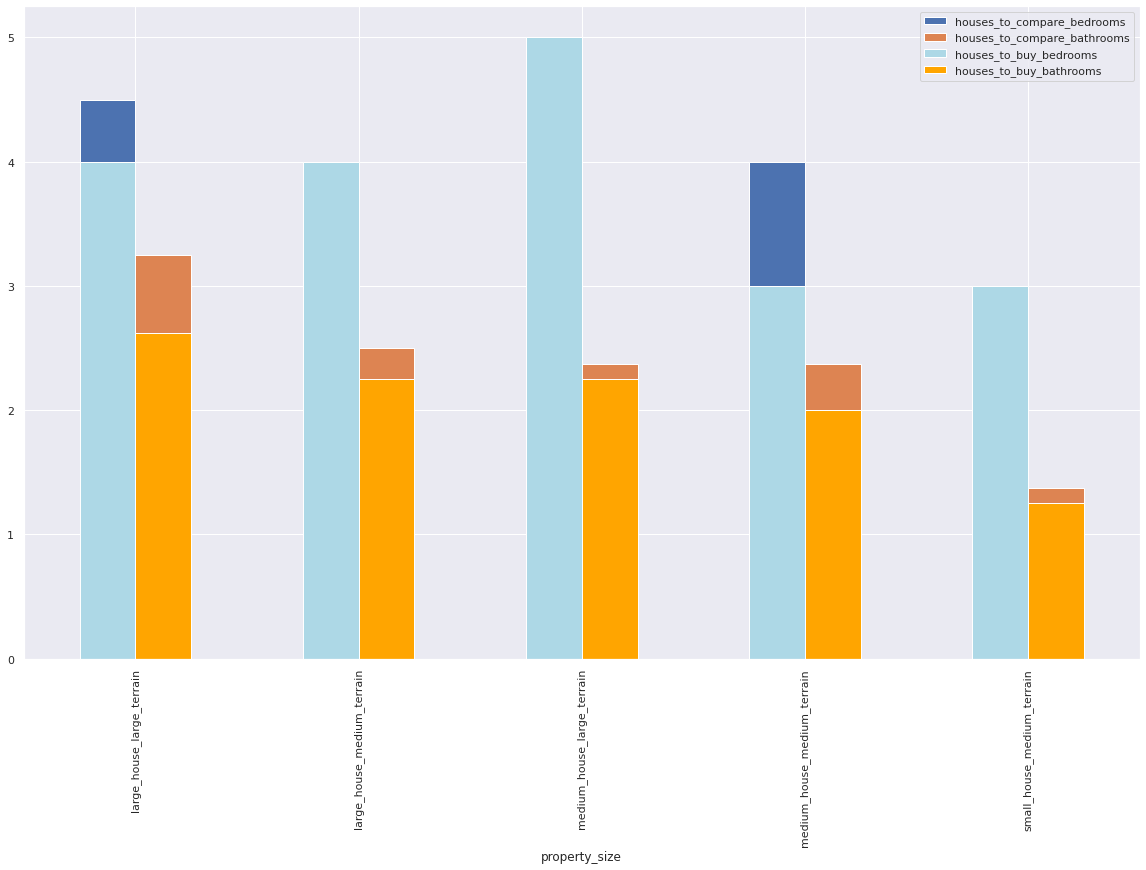

In [85]:
renovation_histograms(house_df_ins, 98005)

##### Conclusions

For example, on the zipcode 98005, the houses to compare, that were the ones above the median price and their condition were higher than 3, have more bathroom amenities on general, and also for properties with living and lot large and medium size.

### 4.1 Test Business Hypothesis 
***

To maybe get new business insights to present additionally on the next meeting.

1. Houses that have a water view, are 20% more expensive on average.


2. Houses with year built older than 1955, are 50% cheaper on average.


3. Houses without basement are 40% bigger than with basement.


4. The growth rate of the houses price YoY (Year over Year) is 10%.


5. Houses with 3 bathrooms have a MoM (Month over Month) growth of 15%.


6. Overall the houses North of the county are generally more expensive than South properties.

#### 4.1.1. Houses that have a water view, are 20% more expensive on average.

In [86]:
price_per_water_front = house_df_eda[['price','waterfront']].groupby('waterfront').mean().reset_index()

print('Average price of houses with water view: ', price_per_water_front.loc[price_per_water_front['waterfront']==1,'price'].values[0],end='\n\n')
print('Average price of houses without water view: ', price_per_water_front.loc[price_per_water_front['waterfront']==0,'price'].values[0],end='\n\n')
print("Average price percentage of houses with a water view above houses without a water view: ",
      str(round(((price_per_water_front.loc[price_per_water_front['waterfront']==1,'price'].values[0])/(price_per_water_front.loc[price_per_water_front['waterfront']==0,'price'].values[0]))*100,2)-100)+'%')

Average price of houses with water view:  1661876.0245398772

Average price of houses without water view:  531563.5998135199

Average price percentage of houses with a water view above houses without a water view:  212.64%


#### 4.1.2. Houses with year built older than 1955, are 50% cheaper on average. 

In [87]:
print('Average price of houses older than 1955: ', house_df_eda.loc[house_df_eda.yr_built < 1955,'price'].mean(),end='\n\n')
print('Average price of houses after 1955: ', house_df_eda.loc[house_df_eda.yr_built > 1955,'price'].mean(),end='\n\n')
print("Average price percentage of houses older than 1955 above houses built after 1955: ",
      str(round((house_df_eda.loc[house_df_eda.yr_built < 1955,'price'].mean()/house_df_eda.loc[house_df_eda.yr_built > 1955,'price'].mean())*100,2)-100)+'%')







Average price of houses older than 1955:  537050.9076898118

Average price of houses after 1955:  542917.1649756227

Average price percentage of houses older than 1955 above houses built after 1955:  -1.0799999999999983%


#### 4.1.3. Houses without basement are 40% bigger than with basement on average. 

In [88]:
print('Total size of houses without basement: ', house_df_ins.loc[house_df_ins.m2_basement == 0,'house_total_m2'].mean(),end='\n\n')
print('Total size of houses with basement: ', house_df_ins.loc[house_df_ins.m2_basement > 0,'house_total_m2'].mean(),end='\n\n')
print("Average total size percentage of houses without basement above houses with basement: ",
      str(round(((house_df_ins.loc[house_df_ins.m2_basement == 0,'house_total_m2'].mean())/(house_df_ins.loc[house_df_ins.m2_basement > 0,'house_total_m2'].mean())*100)-100,2))+'%')

Total size of houses without basement:  1691.9929444689928

Total size of houses with basement:  1449.2179325556733

Average total size percentage of houses without basement above houses with basement:  16.75%


#### 4.1.4. The growth rate of the houses price YoY (Year over Year) is 10%. 

In [89]:
house_df_eda['year'] = house_df_eda['date'].apply(lambda x: x.year)
house_price_per_year = house_df_eda[['year','price']].groupby('year').mean().reset_index()

perc_series_array = np.zeros(len(house_price_per_year))
perc_series_array[:-1] = house_price_per_year.loc[1:,'price']
perc_serie = pd.Series(perc_series_array)
perc_serie

price_perc_YoY = np.zeros(len(house_price_per_year))
price_perc_YoY[1:] = (((perc_serie/house_price_per_year['price'])*100)-100)[:-1]

house_price_per_year['price_perc_YoY'] = price_perc_YoY
house_price_per_year

,year,price,price_perc_YoY
0,2014,539181.43,0.00
1,2015,541988.99,0.52


#### 4.1.5. Houses with 3 bathrooms have a MoM (Month over Month) growth of 15%. 

In [90]:
house_df_eda['year'] = house_df_eda['date'].apply(lambda x: x.year)
house_df_eda['month'] = house_df_eda['date'].apply(lambda x: x.month)
house_price_per_month = house_df_eda[['year','month','price']].groupby(by=['year','month']).mean().reset_index()

perc_series_array = np.zeros(len(house_price_per_month))
perc_series_array[:-1] = house_price_per_month.loc[1:,'price']
perc_serie = pd.Series(perc_series_array)
perc_serie

price_perc_MoM = np.zeros(len(house_price_per_month))
price_perc_MoM[1:] = (((perc_serie/house_price_per_month['price'])*100)-100)[:-1]

house_price_per_month['price_perc_MoM'] = price_perc_MoM
house_price_per_month

,year,month,price,price_perc_MoM
0,2014,5,548080.28,0.00
1,2014,6,558002.20,1.81
2,2014,7,544788.76,-2.37
3,2014,8,536445.28,-1.53
4,2014,9,529253.82,-1.34
5,2014,10,539026.97,1.85
6,2014,11,521961.01,-3.17
7,2014,12,524461.87,0.48
8,2015,1,525870.89,0.27
9,2015,2,507851.37,-3.43


#### 4.1.6. Houses at North of the county are generally more expensive than South houses.

<AxesSubplot:xlabel='region'>

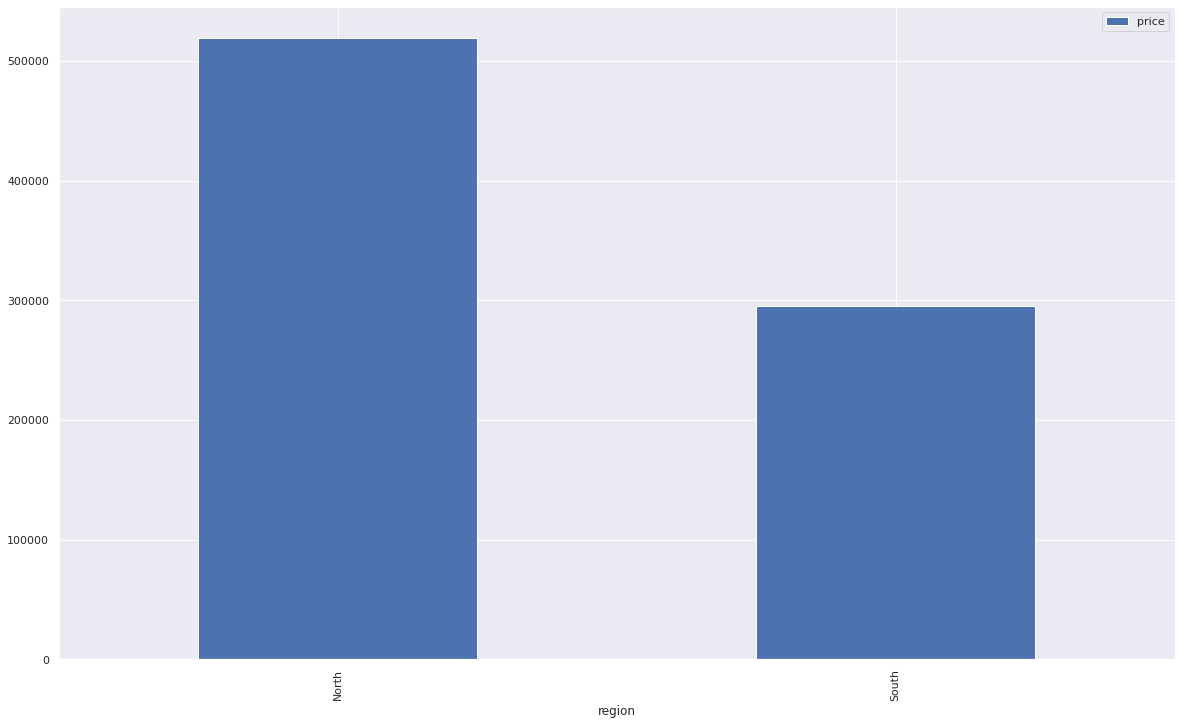

In [91]:
house_df_eda['region'] = house_df_eda['lat'].apply(lambda x: 'North' if x > 47.46 else 'South')

house_grouped_by_region = house_df_eda.groupby(by='region').median().reset_index()

house_grouped_by_region.plot.bar(x='region',y='price')

#### Conclusions

Hypothesis 1 - True

Hypothesis 2 - False

Hypothesis 3 - False

Hypothesis 4 - False

Hypothesis 5 - False

Hypothesis 6 - True

Only the Hypothesis 1 and 6 are True, meaning that maybe houses with no water view in the South could be cheaper and the ones that were already recommended could generate more profit than the ones with water view in the North

## 5. Conclusions

There are 3 investment yield profit scenarios, for some fix and flip or only market appreciation with time, according to some criteria:

1. The profit obtained buying the recommended houses by only considering the zipcode, the property total size category and its condition, with the filters already explained above, is equal to 214,912,301.65\\$

2. If we try to sell all the recommeded houses considering the best season the profit will go up by 10\% with over 237 million \\$.

3. And if we want to be more precise we would want to buy the houses on the areas where the profit is higher, let's say the top 5 zipcodes.

|zipcode	| best_season_profit_est|
| :-----    | :----- |
|	98039	| 321875.00 |
|   98004	| 131043.75 |
|	98112	| 121875.00 |
|	98040	| 108650.00 |
|	98102   | 95000.00 |	

Hence the sum of the median profit for the top 5 zip codes totals 778,443.75\\$ with an initial investment of 4,750,000.0\\$ and a sales revenue of 5,565,827.40\\$  

In [92]:
houses_best_selling_price.head()

,id,date,price,condition,grade,zipcode,bedrooms,bathrooms,lat,long,m2_living,m2_above,m2_basement,m2_lot,house_total_m2,price_m2,living_size,lot_size,house_type,median_price,median_price_m2,status,perc_value_below_median_price,selling_price,profit_est,season,best_season,best_season_median_price,best_season_selling_price,best_season_profit_est
0,1238500451,2015-02-09,130000.00,4,7,98033,3,1.00,47.68,-122.18,103.12,103.12,0.00,698.61,801.73,162.15,small_house,medium_terrain,townhouse,465000.00,483.99,to buy,72.04,195000.00,65000.00,winter,spring,410000.00,204750.00,74750.00
1,1238500451,2015-02-09,130000.00,4,7,98033,3,1.00,47.68,-122.18,103.12,103.12,0.00,698.61,801.73,162.15,small_house,medium_terrain,townhouse,465000.00,483.99,to buy,72.04,195000.00,65000.00,winter,summer,410000.00,204750.00,74750.00
2,5111400086,2014-05-12,110000.00,5,6,98038,3,1.00,47.42,-122.05,116.12,116.12,0.00,4936.98,5053.11,21.77,small_house,large_terrain,mansion,295000.00,34.21,to buy,62.71,159500.00,49500.00,spring,autumn,278750.00,167475.00,57475.00
3,7899800450,2014-08-28,107000.00,4,6,98106,2,1.00,47.52,-122.36,62.24,62.24,0.00,438.49,500.73,213.69,small_house,small_terrain,townhouse,276000.00,631.95,to buy,61.23,160500.00,53500.00,summer,winter,271000.00,168525.00,61525.00
4,2354300456,2015-03-11,130000.00,4,4,98027,2,1.00,47.53,-122.03,55.74,55.74,0.00,139.35,195.09,666.36,small_house,small_terrain,apartment,331000.00,1522.92,to buy,60.73,195000.00,65000.00,winter,autumn,313000.00,204750.00,74750.00


In [95]:
houses_best_selling_price['profit_est'].sum()

214912301.65

In [99]:
houses_best_selling_price['best_season_profit_est'].sum()

237437758.0875

In [98]:
((houses_best_selling_price['best_season_profit_est'].sum()/houses_best_selling_price['profit_est'].sum())*100)-100

10.481231769684499

In [119]:
zipcode_profit_df = houses_best_selling_price[['price', 'selling_price','best_season_profit_est', 'zipcode']].groupby('zipcode').median().reset_index()
zipcode_profit_df.columns = ['zipcode', 'price', 'selling_price', 'best_season_profit_est']

top5_zipcodes = zipcode_profit_df.sort_values(by=['best_season_profit_est','price'],ascending=[False,True]).head(5)

top5_zipcodes

,zipcode,price,selling_price,best_season_profit_est
24,98039,1450000.00,1812500.00,321875.00
3,98004,845000.00,956250.00,131043.75
48,98112,880000.00,983625.00,121875.00
25,98040,830000.00,939881.25,108650.00
41,98102,745000.00,873571.12,95000.00


In [120]:
top5_zipcodes.price.sum()

4750000.0

In [121]:
top5_zipcodes.selling_price.sum()

5565827.375

In [122]:
top5_zipcodes.best_season_profit_est.sum()

778443.75